In [22]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
# import tensorflow_addons as tfa
import random

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
%matplotlib inline

seed = 69
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 1


In [23]:
## Load data
data = np.load("/kaggle/input/marssegmentation/cleaned_mars_for_students.npz")
X_train = data['images']
y_train = data['labels']

X_test = data['test_set']
NUM_CLASSES = len(np.unique(y_train))

In [24]:
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
from scipy.ndimage import distance_transform_edt as distance

class CombinedSegmentationLoss(tf.keras.losses.Loss):
    def __init__(self, 
                 num_classes,
                 class_frequencies=None,
                 alpha=0.25, 
                 gamma=2.0, 
                 focal_weight=1.0, 
                 dice_weight=1.0, 
                 ce_weight=1.0,
                 boundary_weight=1.0,
                 ignore_class=None):
        """
        Combined loss function for semantic segmentation with class balancing.
        
        Args:
            num_classes: Total number of classes including background
            class_frequencies: Array of class frequencies (if None, will be computed during training)
            alpha: Focal loss focusing parameter
            gamma: Focal loss modulating factor
            focal_weight: Weight for focal loss
            dice_weight: Weight for dice loss
            ce_weight: Weight for categorical crossentropy
            boundary_weight: Weight for boundary loss
            ignore_class: Class index to ignore in loss calculation (usually background)
        """
        super().__init__()
        self.num_classes = num_classes
        self.alpha = alpha
        self.gamma = gamma
        self.focal_weight = focal_weight
        self.dice_weight = dice_weight
        self.ce_weight = ce_weight
        self.boundary_weight = boundary_weight
        self.ignore_class = ignore_class
        
        # Initialize class weights if frequencies are provided
        if class_frequencies is not None:
            self.class_weights = self._compute_class_weights(class_frequencies)
        else:
            self.class_weights = None

    def _compute_class_weights(self, class_frequencies):
        """Compute inverse frequency weights for class balancing."""
        eps = 1e-7  # Small epsilon to avoid division by zero
        frequencies = np.array(class_frequencies)
        frequencies[frequencies == 0] = eps
        
        # Inverse frequency weighting
        weights = 1 / (frequencies + eps)
        
        # Normalize weights
        weights = weights / np.sum(weights)

        print("Weigths: ")
        print(tf.constant(weights, dtype=tf.float32))
        
        # Convert to tensor
        return tf.constant(weights, dtype=tf.float32)

    def update_class_weights(self, y_true):
        """Update class weights based on batch statistics."""
        if self.class_weights is None:
            # Calculate class frequencies from current batch
            batch_frequencies = tf.reduce_sum(
                tf.one_hot(tf.cast(y_true, tf.int32), self.num_classes),
                axis=[0, 1, 2]
            )
            self.class_weights = self._compute_class_weights(batch_frequencies)

    def dice_loss(self, y_true, y_pred):
        """Calculate class-weighted Dice loss."""
        # Create mask for non-ignored classes
        mask = tf.cast(y_true != self.ignore_class, tf.float32)
        
        # Convert sparse to one-hot
        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), self.num_classes)
        
        # Apply class weights
        weighted_pred = y_pred * self.class_weights[tf.newaxis, tf.newaxis, tf.newaxis, :]
        
        # Calculate Dice coefficient with class weights
        intersection = tf.reduce_sum(y_true_one_hot * weighted_pred * mask[..., tf.newaxis], axis=[0, 1, 2])
        union = tf.reduce_sum(y_true_one_hot * mask[..., tf.newaxis], axis=[0, 1, 2]) + \
                tf.reduce_sum(weighted_pred * mask[..., tf.newaxis], axis=[0, 1, 2])
        
        dice = (2.0 * intersection + K.epsilon()) / (union + K.epsilon())
        return 1.0 - tf.reduce_mean(dice)

    def focal_loss(self, y_true, y_pred):
        """Calculate class-weighted Focal loss."""
        mask = tf.cast(y_true != self.ignore_class, tf.float32)
        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), self.num_classes)
        
        # Apply class weights to predictions
        weighted_pred = y_pred * self.class_weights[tf.newaxis, tf.newaxis, tf.newaxis, :]
        
        # Calculate focal loss with class weights
        ce = -y_true_one_hot * tf.math.log(weighted_pred + K.epsilon())
        weight = tf.pow(1.0 - weighted_pred, self.gamma)
        fl = self.alpha * weight * ce
        
        fl = fl * mask[..., tf.newaxis]
        return tf.reduce_mean(tf.reduce_sum(fl, axis=-1))

    
    def boundary_loss(self, y_true, y_pred, epsilon=1e-7):
        """Calculate boundary-aware loss using image gradients."""
        # Convert sparse to one-hot
        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), self.num_classes)
    
        # Compute gradients of the smoothed y_true
        dy_true, dx_true = tf.image.image_gradients(y_true_one_hot)
       
        # Compute gradients of the predicted probabilities
        dy_pred, dx_pred = tf.image.image_gradients(y_pred)
   
        # Calculate boundary loss
        boundary_loss = tf.reduce_mean(
            tf.abs(dy_pred - dy_true) + tf.abs(dx_pred - dx_true) + epsilon,
            axis=[1, 2, 3]
        )
        
        return tf.reduce_mean(boundary_loss)

    def categorical_crossentropy(self, y_true, y_pred):
        """Calculate class-weighted categorical crossentropy."""
        mask = tf.cast(y_true != self.ignore_class, tf.float32)
        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), self.num_classes)
        
        # Apply class weights to predictions
        weighted_pred = y_pred * self.class_weights[tf.newaxis, tf.newaxis, tf.newaxis, :]
        
        ce = -y_true_one_hot * tf.math.log(weighted_pred + K.epsilon())
        ce = ce * mask[..., tf.newaxis]
        return tf.reduce_mean(tf.reduce_sum(ce, axis=-1))

    def call(self, y_true, y_pred):
        """Combine all losses with their respective weights."""
        # Update class weights if necessary
        self.update_class_weights(y_true)
        
        # Calculate individual losses
        fl = self.focal_loss(y_true, y_pred) * self.focal_weight
        dl = self.dice_loss(y_true, y_pred) * self.dice_weight
        ce = self.categorical_crossentropy(y_true, y_pred) * self.ce_weight
        bl = self.boundary_loss(y_true, y_pred) * self.boundary_weight
        
        return fl + dl + ce + bl

In [25]:
import tensorflow as tf
import tensorflow.keras.layers as tfkl

def custom_attention_block(x, g, reduction_ratio=8):
    """
    Custom attention block with dimension matching and channel reduction
    
    Args:
        x: Feature map to be enhanced
        g: Gating signal
        reduction_ratio: Channel reduction factor
    
    Returns:
        Attention-enhanced feature map
    """
    # Ensure x and g have compatible shapes
    x_channels = x.shape[-1]
    g_channels = g.shape[-1]
    
    # Reduce g's dimensionality if needed
    if g_channels > x_channels:
        g = tfkl.Conv2D(x_channels, (1,1), padding='same')(g)
    
    # Query, Key, Value projections
    query = tfkl.Conv2D(x_channels // reduction_ratio, (1,1), activation='relu')(x)
    key = tfkl.Conv2D(x_channels // reduction_ratio, (1,1), activation='relu')(g)
    value = tfkl.Conv2D(x_channels, (1,1), activation='relu')(x)
    
    # Compute attention scores
    attention_scores = tfkl.Dot(axes=[3, 3])([query, key])
    attention_scores = tfkl.Softmax()(attention_scores)
    
    # Apply attention
    attended_features = tfkl.Dot(axes=[3, 1])([attention_scores, value])
    
    # Residual connection
    return tfkl.Add()([x, attended_features])
def squeeze_excitation_block(input_tensor, reduction_ratio=16):
    channels = input_tensor.shape[-1]
    # Squeeze
    x = tfkl.GlobalAveragePooling2D()(input_tensor)
    # Excitation
    x = tfkl.Dense(channels // reduction_ratio, activation='relu')(x)
    x = tfkl.Dense(channels, activation='sigmoid')(x)
    # Reshape and multiply
    x = tfkl.Reshape((1, 1, channels))(x)
    return tfkl.multiply([input_tensor, x])

def global_context_module(input_tensor):
    channels = input_tensor.shape[-1]
    # Global context
    context = tfkl.GlobalAveragePooling2D()(input_tensor)
    context = tfkl.Dense(channels // 2, activation='relu')(context)
    context = tfkl.Dense(channels, activation='sigmoid')(context)
    context = tfkl.Reshape((1, 1, channels))(context)
    # Broadcast and multiply
    return tfkl.multiply([input_tensor, context])

def parallel_dilated_conv_block(input_tensor, filters):
    # Three parallel branches with different dilation rates
    d1 = tfkl.Conv2D(filters//4, kernel_size=3, padding='same', dilation_rate=1)(input_tensor)
    d2 = tfkl.Conv2D(filters//4, kernel_size=3, padding='same', dilation_rate=2)(input_tensor)
    d4 = tfkl.Conv2D(filters//4, kernel_size=3, padding='same', dilation_rate=4)(input_tensor)
    d8 = tfkl.Conv2D(filters//4, kernel_size=3, padding='same', dilation_rate=8)(input_tensor)
    
    # Concatenate all branches
    return tfkl.Concatenate()([d1, d2, d4, d8])

def enhanced_unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Main path
    x1 = tfkl.Conv2D(filters, kernel_size, padding='same')(input_tensor)
    x = tfkl.BatchNormalization()(x1)
    x = tfkl.Activation('relu')(x)
    
    x = tfkl.Conv2D(filters, kernel_size, padding='same')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)

    x = tfkl.Add()([x, x1])
    return x


def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    x = input_tensor
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1), kernel_regularizer =tf.keras.regularizers.l2(1e-4))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)
    return x


def unet3plus(encoder_layer, output_channels, filters):
    """ UNet3+ base model """

    """ Encoder """
    e1 = encoder_layer[0]
    e2 = encoder_layer[1]
    e3 = encoder_layer[2]
    e4 = encoder_layer[3]
    # e5 = encoder_layer[4]

    """ Decoder """
    cat_channels = filters[0]
    cat_blocks = len(filters)
    upsample_channels = cat_blocks * cat_channels

    """ d4 """
    e1_d4 = tfkl.MaxPooling2D(pool_size=(8, 8))(e1)  # 320*320*64  --> 40*40*64
    e1_d4 = unet_block(e1_d4, cat_channels, stack=1, name = "e1_d4")  # 320*320*64  --> 40*40*64

    e2_d4 = tfkl.MaxPooling2D(pool_size=(4, 4))(e2)  # 160*160*128 --> 40*40*128
    e2_d4 = unet_block(e2_d4, cat_channels, stack=1, name = "e2_d4")  # 160*160*128 --> 40*40*64

    e3_d4 = tfkl.MaxPooling2D(pool_size=(2, 2))(e3)  # 80*80*256  --> 40*40*256
    e3_d4 = unet_block(e3_d4, cat_channels, stack=1, name = "e3_d4")  # 80*80*256  --> 40*40*64

    e4_d4 = unet_block(e4, cat_channels, stack=1, name = "e4_d4")  # 40*40*512  --> 40*40*64

    # e5_d4 = tfkl.UpSampling2D(size=(2, 2), interpolation='bilinear')(e5)  # 80*80*256  --> 40*40*256
    # e5_d4 = unet_block(e5_d4, cat_channels, stack=1, name = "e5_d4")  # 20*20*1024  --> 20*20*64

    d4 = tfkl.Concatenate()([e1_d4, e2_d4, e3_d4, e4_d4])
    d4 = unet_block(d4, upsample_channels, stack=1, name = "d4")  # 40*40*320  --> 40*40*320

    """ d3 """
    e1_d3 = tfkl.MaxPooling2D(pool_size=(4, 4))(e1)  # 320*320*64 --> 80*80*64
    e1_d3 = unet_block(e1_d3, cat_channels, stack=1, name = "e1_d3")  # 80*80*64 --> 80*80*64

    e2_d3 = tfkl.MaxPooling2D(pool_size=(2, 2))(e2)  # 160*160*256 --> 80*80*256
    e2_d3 = unet_block(e2_d3, cat_channels, stack=1, name = "e2_d3")  # 80*80*256 --> 80*80*64

    e3_d3 = unet_block(e3, cat_channels, stack=1, name = "e3_d3")  # 80*80*512 --> 80*80*64

    e4_d3 = tfkl.UpSampling2D(size=(2, 2), interpolation='bilinear')(d4)  # 40*40*320 --> 80*80*320
    e4_d3 = unet_block(e4_d3, cat_channels, stack=1, name = "e4_d3")  # 80*80*320 --> 80*80*64

    # e5_d3 = tfkl.UpSampling2D(size=(4, 4), interpolation='bilinear')(e5)  # 20*20*320 --> 80*80*320
    # e5_d3 = unet_block(e5_d3, cat_channels, stack=1, name = "e5_d3")  # 80*80*320 --> 80*80*64

    d3 = tfkl.Concatenate()([e1_d3, e2_d3, e3_d3, e4_d3])
    d3 = unet_block(d3, upsample_channels, stack=1, name = "d3")  # 80*80*320 --> 80*80*320

    """ d2 """
    e1_d2 = tfkl.MaxPooling2D(pool_size=(2, 2))(e1)  # 320*320*64 --> 160*160*64
    e1_d2 = unet_block(e1_d2, cat_channels, stack=1, name = "e1_d2")  # 160*160*64 --> 160*160*64

    e2_d2 = unet_block(e2, cat_channels, stack=1)  # 160*160*256 --> 160*160*64

    d3_d2 = tfkl.UpSampling2D(size=(2, 2), interpolation='bilinear')(d3)  # 80*80*320 --> 160*160*320
    d3_d2 = unet_block(d3_d2, cat_channels, stack=1, name = "d3_d2")  # 160*160*320 --> 160*160*64

    d4_d2 = tfkl.UpSampling2D(size=(4, 4), interpolation='bilinear')(d4)  # 40*40*320 --> 160*160*320
    d4_d2 = unet_block(d4_d2, cat_channels, stack=1, name = "d4_d2")  # 160*160*320 --> 160*160*64

    # e5_d2 = tfkl.UpSampling2D(size=(8, 8), interpolation='bilinear')(e5)  # 20*20*320 --> 160*160*320
    # e5_d2 = unet_block(e5_d2, cat_channels, stack=1, name = "e5_d2")  # 160*160*320 --> 160*160*64

    d2 = tfkl.Concatenate()([e1_d2, e2_d2, d3_d2, d4_d2])
    d2 = unet_block(d2, upsample_channels, stack=1, name = "d2")  # 160*160*320 --> 160*160*320

    """ d1 """
    e1_d1 = unet_block(e1, cat_channels, stack=1, name = "e1_d1")  # 320*320*64 --> 320*320*64

    d2_d1 = tfkl.UpSampling2D(size=(2, 2), interpolation='bilinear')(d2)  # 160*160*320 --> 320*320*320
    d2_d1 = unet_block(d2_d1, cat_channels, stack=1, name = "d2_d1")  # 160*160*320 --> 160*160*64

    d3_d1 = tfkl.UpSampling2D(size=(4, 4), interpolation='bilinear')(d3)  # 80*80*320 --> 320*320*320
    d3_d1 = unet_block(d3_d1, cat_channels, stack=1, name = "d3_d1")  # 320*320*320 --> 320*320*64

    d4_d1 = tfkl.UpSampling2D(size=(8, 8), interpolation='bilinear')(d4)  # 40*40*320 --> 320*320*320
    d4_d1 = unet_block(d4_d1, cat_channels, stack=1, name = "d4_d1")  # 320*320*320 --> 320*320*64

    # e5_d1 = tfkl.UpSampling2D(size=(16, 16), interpolation='bilinear')(e5)  # 20*20*320 --> 320*320*320
    # e5_d1 = unet_block(e5_d1, cat_channels, stack=1, name = "e5_d1")  # 320*320*320 --> 320*320*64

    d1 = tfkl.Concatenate()([e1_d1, d2_d1, d3_d1, d4_d1])
    d1 = unet_block(d1, upsample_channels, stack=1, name = "d1")  # 320*320*320 --> 320*320*320

    # last layer does not have batchnorm and relu
    output_layer = tfkl.Conv2D(output_channels, kernel_size=1, padding='same', activation="softmax", name='output_layer')(d1)
    return output_layer

def get_unet3plus_model(input_shape=(64, 128, 1), num_classes=NUM_CLASSES, seed=seed):
    """
    Create UNet3+ model with the same structure as the original enhanced UNet
    
    Args:
        input_shape: Input image dimensions
        num_classes: Number of output classes
        seed: Random seed for reproducibility
    
    Returns:
        Compiled UNet3+ model
    """
    tf.random.set_seed(seed)
    
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    
    # Downsampling path (encoder)
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)
    d1 = tfkl.Dropout(0.3)(d1)
    
    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)
    d2 = tfkl.Dropout(0.3)(d2)
    
    down_block_3 = unet_block(d2, 128, name='down_block3_')
    d3 = tfkl.MaxPooling2D()(down_block_3)
    d3 = tfkl.Dropout(0.3)(d3)
    
    # down_block_4 = unet_block(d3, 256, name='down_block4_')
    # d4 = tfkl.MaxPooling2D()(down_block_4)
    # d4 = tfkl.Dropout(0.4)(d4)
    
    # Bottleneck with enhancements
    bottleneck = parallel_dilated_conv_block(d3, 256)
    bottleneck = tfkl.BatchNormalization()(bottleneck)
    bottleneck = tfkl.Activation('relu')(bottleneck)
    bottleneck = global_context_module(bottleneck)
    bottleneck = squeeze_excitation_block(bottleneck)

    
    # UNet3+ decoder with multiple inputs
    encoder_layers = [down_block_1, down_block_2, down_block_3, bottleneck]
    filters = [32, 64, 128, 256]  # Corresponding to encoder block sizes
    
    output = unet3plus(encoder_layers, num_classes, filters)
    
    model = tf.keras.Model(inputs=input_layer, outputs=output, name='UNet3Plus')
    return model

In [26]:
def compute_class_frequencies(y_train):
    """
    Compute pixel-wise class frequencies for semantic segmentation data.
    Safely handles both integer and float labels.
    
    Args:
        y_train: Training masks of shape (N, H, W) or (N, H, W, 1)
                Can contain either integer or float labels
    
    Returns:
        class_frequencies: Array of normalized class frequencies
    """
    # Handle 4D masks (N, H, W, 1)
    if len(y_train.shape) == 4 and y_train.shape[-1] == 1:
        y_train = np.squeeze(y_train, axis=-1)
    
    # Convert to integer labels safely
    y_train_int = np.round(y_train).astype(np.int64)
    
    # Get total number of pixels
    total_pixels = y_train_int.size
    
    # Count occurrences of each class
    class_counts = np.bincount(y_train_int.flatten())
    
    # Convert counts to frequencies
    class_frequencies = class_counts / total_pixels
    
    # Print statistics
    print(f"\nClass Distribution Statistics:")
    print(f"Total pixels analyzed: {total_pixels}")
    print(f"Number of unique classes found: {len(class_counts)}")
    print("\nPer-class breakdown:")
    for class_idx, (count, freq) in enumerate(zip(class_counts, class_frequencies)):
        percentage = freq * 100
        print(f"Class {class_idx:2d}: {count:8d} pixels ({percentage:6.2f}%)")
    
    return class_frequencies

In [27]:
frequencies = compute_class_frequencies(y_train)
print(frequencies)


Class Distribution Statistics:
Total pixels analyzed: 20520960
Number of unique classes found: 5

Per-class breakdown:
Class  0:  4988826 pixels ( 24.31%)
Class  1:  6957538 pixels ( 33.90%)
Class  2:  4776810 pixels ( 23.28%)
Class  3:  3770823 pixels ( 18.38%)
Class  4:    26963 pixels (  0.13%)
[0.2431088  0.33904544 0.23277712 0.18375471 0.00131392]


In [28]:
BATCH_SIZE = 64

LEARNING_RATE = .0001

PATIENCE = 30

EPOCHS = 1000

Model: "UNet3Plus"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv1 │ (None, 64, 128, │       320 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn1   │ (None, 64, 128, │       128 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv2 │ (None, 64, 128, │     9,248 │ down_block1_a… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn2   │ (None, 64, 128, │       128 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_9   │ (None, 32, 64,  │         0 │ down_block1_a… │   -   │
│ (MaxPooling2D)    │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dropout_3         │ (None, 32, 64,  │         0 │ max_pooling2d… │   -   │
│ (Dropout)         │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv1 │ (None, 32, 64,  │    18,496 │ dropout_3[0][… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn1   │ (None, 32, 64,  │       256 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv2 │ (None, 32, 64,  │    36,928 │ down_block2_a… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn2   │ (None, 32, 64,  │       256 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_10  │ (None, 16, 32,  │         0 │ down_block2_a… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dropout_4         │ (None, 16, 32,  │         0 │ max_pooling2d… │   - 

 Total params: 1,715,189 (6.54 MB)

 Trainable params: 1,711,733 (6.53 MB)

 Non-trainable params: 3,456 (13.50 KB)

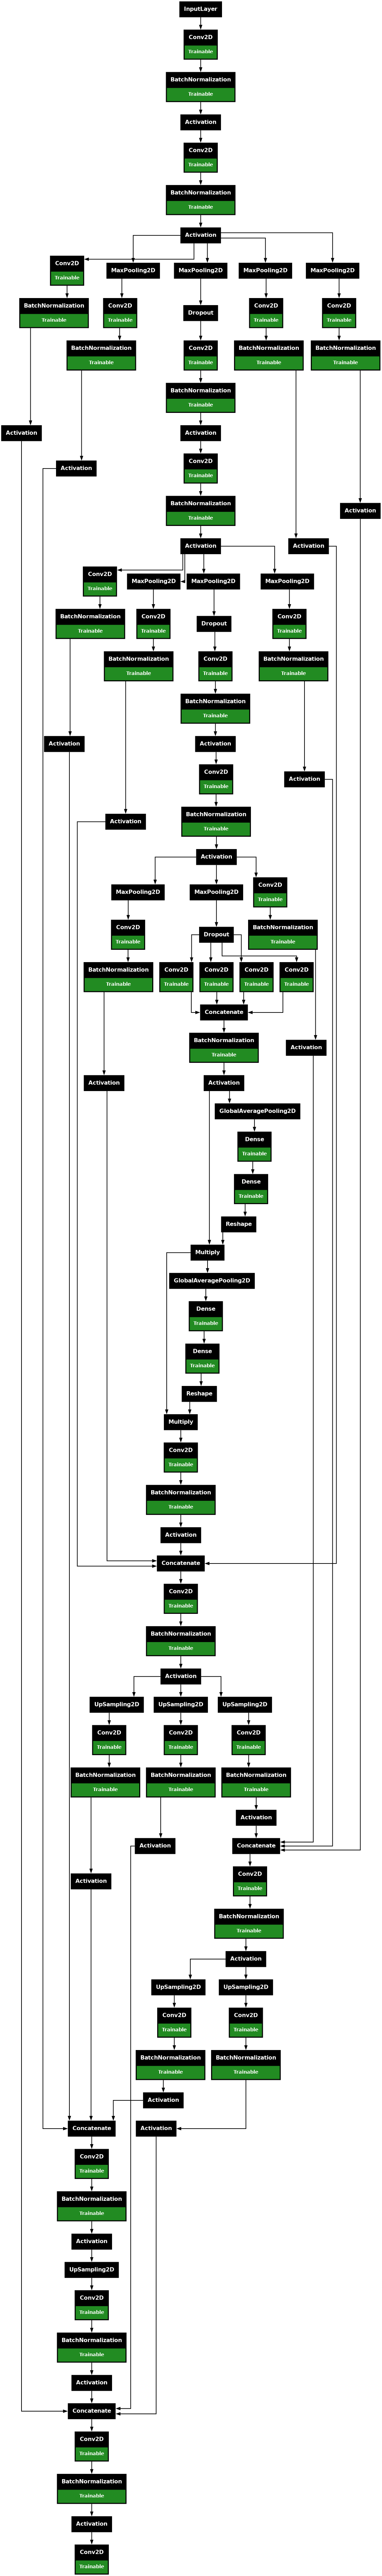

In [29]:
model = get_unet3plus_model()


# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [30]:
def load_single_image(image_path, label_path, input_size=(64, 128)):
    """
    Load a single image-label pair with the correct shape.
    """

    # Read and preprocess the image
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, channels=3)  # Ensure 3 channels
    image = tf.image.resize(image, input_size)   # Resize to fixed size
    image = tf.cast(image, tf.float32) / 255.0

    # Read and preprocess the label
    label = tf.io.read_file(label_path)
    label = tf.io.decode_png(label, channels=1)  # Ensure single channel
    label = tf.image.resize(label, input_size, method='bilinear')  # Resize to fixed size
    label = tf.cast(label, tf.int32)

    return image, label

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def random_rotate_images_and_labels(images, labels):
    """
    Function to perform random arbitrary rotation on images and their corresponding labels.
    
    Parameters:
    images (numpy array): Array of grayscale images.
    labels (numpy array): Array of labels corresponding to the images.
    
    Returns:
    rotated_images (numpy array): Array of rotated images.
    rotated_labels (numpy array): Array of rotated labels.
    """
    
    # Create an ImageDataGenerator for random rotation
    datagen = ImageDataGenerator(rotation_range=90)
    
    # Apply the random rotation to each image and its corresponding label
    rotated_images = []
    rotated_labels = []
    
    for img, lbl in zip(images, labels):
        # Expand dimensions to match the expected input shape for ImageDataGenerator
        img = np.expand_dims(img, axis=-1)  # Add channel dimension
        lbl = np.expand_dims(lbl, axis=-1)  # Add channel dimension
        
        # Perform random rotation
        img_rotated = datagen.flow(img[np.newaxis, ...], batch_size=1)[0]
        lbl_rotated = datagen.flow(lbl[np.newaxis, ...], batch_size=1)[0]
        
        # Squeeze the dimensions back to original shape
        rotated_images.append(np.squeeze(img_rotated))
        rotated_labels.append(np.squeeze(lbl_rotated))
    
    return np.array(rotated_images), np.array(rotated_labels)

In [32]:
@tf.function
def random_flip_and_solarize(image, label, 
                             flip_lr_seed=None, flip_ud_seed=None, 
                             solarize_seed=None, brightness_seed=None,
                             saturation_seed=None, 
                             threshold=128.0, solarize_prob=0.2, 
                             saturation_factor=(0.5, 1.5),
                             brightness_delta=0.1):
    """Applies random flips (horizontal and vertical), solarization, saturation, and brightness adjustment."""
    
    if flip_lr_seed is None:
        flip_lr_seed = np.random.randint(0, 1000000)
    if flip_ud_seed is None:
        flip_ud_seed = np.random.randint(0, 1000000)
    if solarize_seed is None:
        solarize_seed = np.random.randint(0, 1000000)
    if brightness_seed is None:
        brightness_seed = np.random.randint(0, 1000000)
    if saturation_seed is None:
        saturation_seed = np.random.randint(0, 1000000)
    
    image = tf.expand_dims(tf.expand_dims(image, 0), -1)
    label = tf.expand_dims(tf.expand_dims(label, 0), -1)
    
    # Left-right flip
    flip_lr_prob = tf.random.uniform([], seed=flip_lr_seed)
    image = tf.cond(flip_lr_prob > 0.5,
                    lambda: tf.image.flip_left_right(image),
                    lambda: image)
    label = tf.cond(flip_lr_prob > 0.5,
                    lambda: tf.image.flip_left_right(label),
                    lambda: label)
    
    # Up-down flip
    flip_ud_prob = tf.random.uniform([], seed=flip_ud_seed)
    image = tf.cond(flip_ud_prob > 0.5,
                    lambda: tf.image.flip_up_down(image),
                    lambda: image)
    label = tf.cond(flip_ud_prob > 0.5,
                    lambda: tf.image.flip_up_down(label),
                    lambda: label)
    
    # Solarization
    def solarize(img):
        return tf.where(img > threshold, 255.0 - img, img)
    
    solarize_rand = tf.random.uniform([], seed=solarize_seed)
    image = tf.cond(solarize_rand < solarize_prob,
                    lambda: solarize(image),
                    lambda: image)
    
    # # Random Brightness --> not so useful
    # brightness_rand = tf.random.uniform([], minval=-brightness_delta, 
    #                                      maxval=brightness_delta, 
    #                                      seed=brightness_seed)
    # image = tf.image.adjust_brightness(image, brightness_rand)
    
    image = tf.squeeze(image)
    label = tf.squeeze(label)
    
    return image, label


In [33]:
def make_dataset(image_paths, label_paths, batch_size, shuffle=True, augment=False, solarize_seed=None):

    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Create dataset from file paths

    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Load images and labels
    # dataset = dataset.map(
    #     load_single_image,
    #     num_parallel_calls=tf.data.AUTOTUNE
    # )

    # Apply category mapping
    dataset = dataset.map(
        lambda x, y: (x, int(y)),
        num_parallel_calls=tf.data.AUTOTUNE

    )

    if augment:
        dataset = dataset.map(
            lambda x, y: random_flip_and_solarize(x, y, solarize_seed=seed),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [34]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=300, random_state=seed
)

In [35]:
# Create the datasets

print("Creating datasets...")

train_dataset = make_dataset(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    solarize_seed=seed
)

X2_train, y2_train = random_rotate_images_and_labels(X_train, y_train)

train_dataset = make_dataset(
    np.concatenate((X2_train, X_train), axis=0),
    np.concatenate((y2_train, y_train), axis=0),
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    solarize_seed=seed+1
)

val_dataset = make_dataset(
    X_val, y_val,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# test_dataset = make_dataset(
#     test_img, test_lbl,
#     batch_size=BATCH_SIZE,
#     shuffle=False
# )

print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Creating datasets...
Datasets created!

Input shape: (64, 128)
Images shape: (64, 64, 128)
Labels shape: (64, 64, 128)
Labels dtype: <dtype: 'int32'>


In [36]:
def create_segmentation_colormap(num_classes):

    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]
    return colored

In [37]:
# Define custom Mean Intersection Over Union metric

class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)



# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image_path, label_path, frequency=5):
        super().__init__()
        self.image_path = image_path
        self.label_path = label_path
        self.frequency = frequency


    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = self.image_path, self.label_path
            label = label
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = NUM_CLASSES
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0], cmap='gray')
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label, colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [38]:
LEARNING_RATE = .001

# Compile the model
print("Compiling model...")

# Compute frequencies from your training data
class_frequencies = compute_class_frequencies(y_train)

# Initialize loss with computed frequencies
combined_loss = CombinedSegmentationLoss(
    num_classes=NUM_CLASSES,
    class_frequencies=class_frequencies,
    alpha=0.25,
    gamma=2.0,
    focal_weight=0,
    dice_weight=0.25,
    ce_weight=.5,
    boundary_weight=0.25,
    ignore_class=0
)

model.compile(
    loss=combined_loss,
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)

print("Model compiled!")

Compiling model...

Class Distribution Statistics:
Total pixels analyzed: 18063360
Number of unique classes found: 5

Per-class breakdown:
Class  0:  4329340 pixels ( 23.97%)
Class  1:  6148209 pixels ( 34.04%)
Class  2:  4263877 pixels ( 23.61%)
Class  3:  3302623 pixels ( 18.28%)
Class  4:    19311 pixels (  0.11%)
Weigths: 
tf.Tensor([0.00438212 0.00308573 0.0044494  0.00574443 0.9823383 ], shape=(5,), dtype=float32)
Model compiled!


In [39]:
# Setup callbacks

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

viz_callback = VizCallback(X_train[97], y_train[97])

In [40]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]


Epoch 1/1000


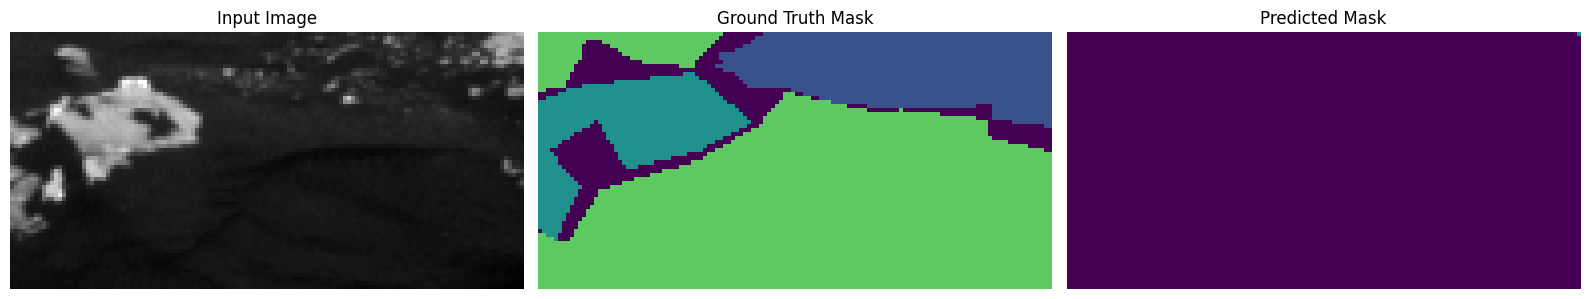

35/35 - 87s - 2s/step - accuracy: 0.4434 - loss: 2.9220 - mean_iou: 0.2422 - val_accuracy: 0.2413 - val_loss: 6.4558 - val_mean_iou: 0.0040
Epoch 2/1000
35/35 - 11s - 314ms/step - accuracy: 0.5296 - loss: 2.7742 - mean_iou: 0.3226 - val_accuracy: 0.4462 - val_loss: 3.0108 - val_mean_iou: 0.2053
Epoch 3/1000
35/35 - 11s - 314ms/step - accuracy: 0.5779 - loss: 2.7222 - mean_iou: 0.3717 - val_accuracy: 0.4803 - val_loss: 2.8746 - val_mean_iou: 0.2604
Epoch 4/1000
35/35 - 11s - 313ms/step - accuracy: 0.5926 - loss: 2.6929 - mean_iou: 0.3874 - val_accuracy: 0.4728 - val_loss: 2.9304 - val_mean_iou: 0.2536
Epoch 5/1000
35/35 - 11s - 314ms/step - accuracy: 0.6147 - loss: 2.6610 - mean_iou: 0.4123 - val_accuracy: 0.5160 - val_loss: 2.8056 - val_mean_iou: 0.3001
Epoch 6/1000


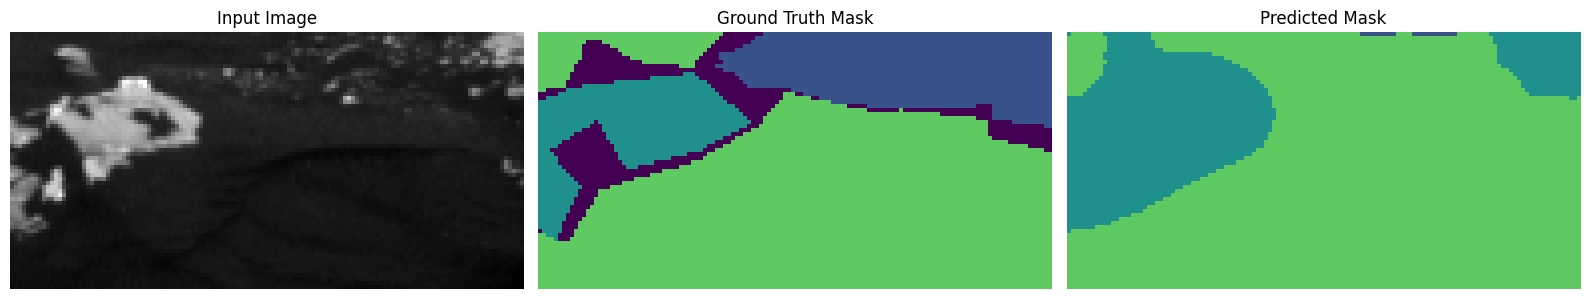

35/35 - 11s - 323ms/step - accuracy: 0.6212 - loss: 2.6481 - mean_iou: 0.4198 - val_accuracy: 0.4861 - val_loss: 2.8699 - val_mean_iou: 0.2690
Epoch 7/1000
35/35 - 11s - 313ms/step - accuracy: 0.6191 - loss: 2.6409 - mean_iou: 0.4126 - val_accuracy: 0.4723 - val_loss: 3.3096 - val_mean_iou: 0.2505
Epoch 8/1000
35/35 - 11s - 314ms/step - accuracy: 0.6393 - loss: 2.6121 - mean_iou: 0.4462 - val_accuracy: 0.5460 - val_loss: 2.7381 - val_mean_iou: 0.4496
Epoch 9/1000
35/35 - 11s - 314ms/step - accuracy: 0.6386 - loss: 2.6007 - mean_iou: 0.4392 - val_accuracy: 0.5614 - val_loss: 2.7197 - val_mean_iou: 0.4594
Epoch 10/1000
35/35 - 11s - 313ms/step - accuracy: 0.6459 - loss: 2.5868 - mean_iou: 0.4627 - val_accuracy: 0.5335 - val_loss: 2.7231 - val_mean_iou: 0.4490
Epoch 11/1000


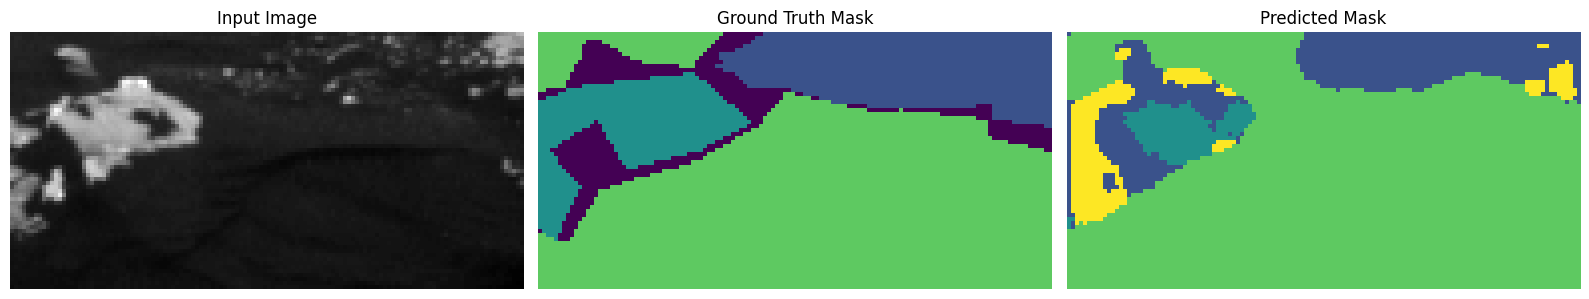

35/35 - 11s - 321ms/step - accuracy: 0.6459 - loss: 2.5803 - mean_iou: 0.5719 - val_accuracy: 0.5224 - val_loss: 2.7520 - val_mean_iou: 0.3944
Epoch 12/1000
35/35 - 11s - 314ms/step - accuracy: 0.6461 - loss: 2.5741 - mean_iou: 0.4566 - val_accuracy: 0.6135 - val_loss: 2.6272 - val_mean_iou: 0.5279
Epoch 13/1000
35/35 - 11s - 315ms/step - accuracy: 0.6499 - loss: 2.5680 - mean_iou: 0.5795 - val_accuracy: 0.6223 - val_loss: 2.6003 - val_mean_iou: 0.5426
Epoch 14/1000
35/35 - 11s - 313ms/step - accuracy: 0.6610 - loss: 2.5506 - mean_iou: 0.6004 - val_accuracy: 0.5681 - val_loss: 2.6976 - val_mean_iou: 0.4707
Epoch 15/1000
35/35 - 11s - 313ms/step - accuracy: 0.6543 - loss: 2.5503 - mean_iou: 0.5926 - val_accuracy: 0.5736 - val_loss: 2.6305 - val_mean_iou: 0.4773
Epoch 16/1000


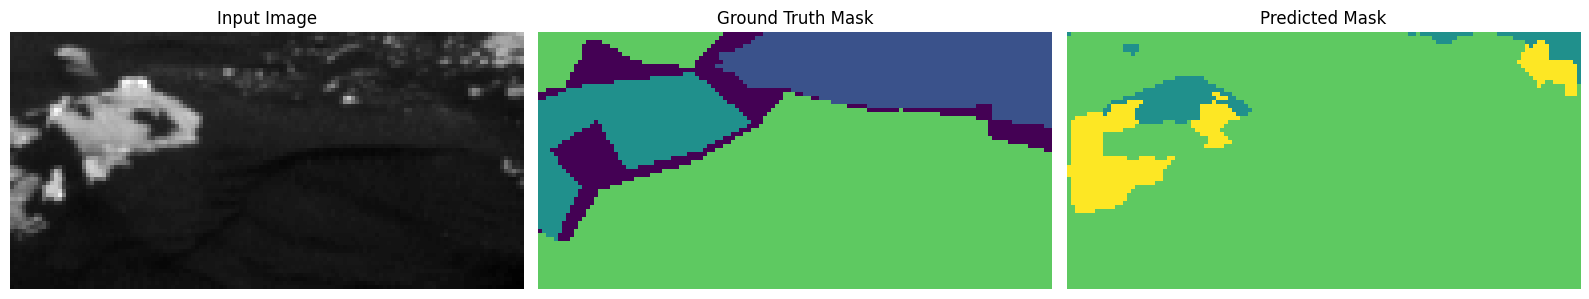

35/35 - 11s - 323ms/step - accuracy: 0.6534 - loss: 2.5466 - mean_iou: 0.4776 - val_accuracy: 0.6031 - val_loss: 2.6294 - val_mean_iou: 0.5106
Epoch 17/1000
35/35 - 11s - 313ms/step - accuracy: 0.6605 - loss: 2.5361 - mean_iou: 0.4831 - val_accuracy: 0.6125 - val_loss: 2.5810 - val_mean_iou: 0.5370
Epoch 18/1000
35/35 - 11s - 313ms/step - accuracy: 0.6587 - loss: 2.5327 - mean_iou: 0.4824 - val_accuracy: 0.5158 - val_loss: 2.7954 - val_mean_iou: 0.3947
Epoch 19/1000
35/35 - 11s - 314ms/step - accuracy: 0.6659 - loss: 2.5268 - mean_iou: 0.6155 - val_accuracy: 0.6463 - val_loss: 2.5465 - val_mean_iou: 0.5795
Epoch 20/1000
35/35 - 11s - 314ms/step - accuracy: 0.6713 - loss: 2.5157 - mean_iou: 0.6327 - val_accuracy: 0.6644 - val_loss: 2.5222 - val_mean_iou: 0.6040
Epoch 21/1000


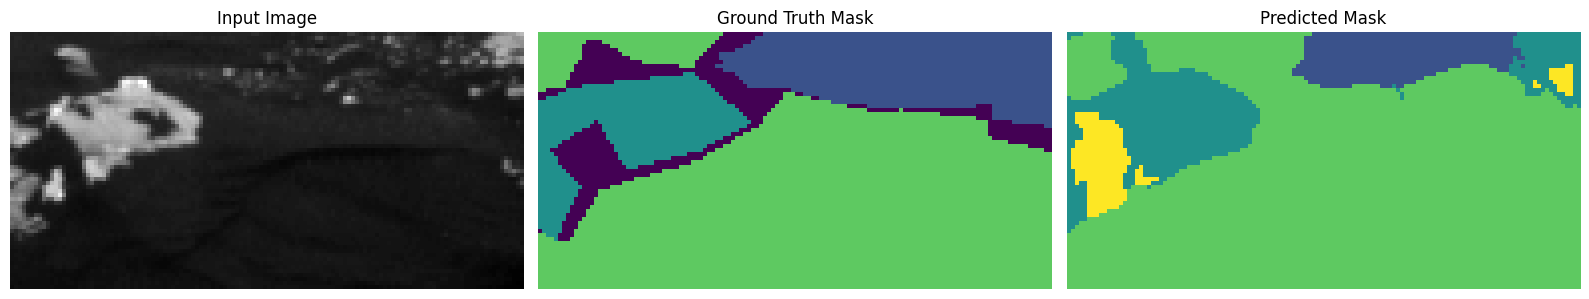

35/35 - 11s - 323ms/step - accuracy: 0.6690 - loss: 2.5160 - mean_iou: 0.6217 - val_accuracy: 0.6525 - val_loss: 2.5341 - val_mean_iou: 0.5782
Epoch 22/1000
35/35 - 11s - 313ms/step - accuracy: 0.6691 - loss: 2.5155 - mean_iou: 0.6085 - val_accuracy: 0.6254 - val_loss: 2.5835 - val_mean_iou: 0.5473
Epoch 23/1000
35/35 - 11s - 312ms/step - accuracy: 0.6719 - loss: 2.5089 - mean_iou: 0.6261 - val_accuracy: 0.6274 - val_loss: 2.5509 - val_mean_iou: 0.5407
Epoch 24/1000
35/35 - 11s - 313ms/step - accuracy: 0.6736 - loss: 2.5069 - mean_iou: 0.6149 - val_accuracy: 0.5985 - val_loss: 2.5904 - val_mean_iou: 0.5080
Epoch 25/1000
35/35 - 11s - 313ms/step - accuracy: 0.6559 - loss: 2.5241 - mean_iou: 0.4767 - val_accuracy: 0.5164 - val_loss: 2.7130 - val_mean_iou: 0.3923
Epoch 26/1000


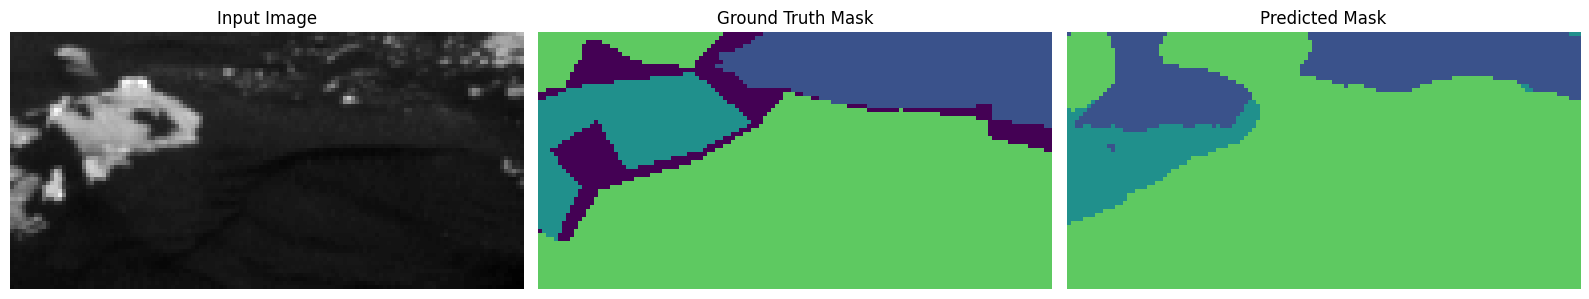

35/35 - 11s - 323ms/step - accuracy: 0.6683 - loss: 2.5082 - mean_iou: 0.6239 - val_accuracy: 0.6206 - val_loss: 2.5726 - val_mean_iou: 0.5593
Epoch 27/1000
35/35 - 11s - 313ms/step - accuracy: 0.6739 - loss: 2.5010 - mean_iou: 0.6321 - val_accuracy: 0.6040 - val_loss: 2.5762 - val_mean_iou: 0.5287
Epoch 28/1000
35/35 - 11s - 313ms/step - accuracy: 0.6703 - loss: 2.5068 - mean_iou: 0.6210 - val_accuracy: 0.5814 - val_loss: 2.6242 - val_mean_iou: 0.3860
Epoch 29/1000
35/35 - 11s - 314ms/step - accuracy: 0.6784 - loss: 2.4926 - mean_iou: 0.6396 - val_accuracy: 0.6566 - val_loss: 2.5168 - val_mean_iou: 0.6284
Epoch 30/1000
35/35 - 11s - 313ms/step - accuracy: 0.6767 - loss: 2.4923 - mean_iou: 0.6561 - val_accuracy: 0.6757 - val_loss: 2.4951 - val_mean_iou: 0.6182
Epoch 31/1000


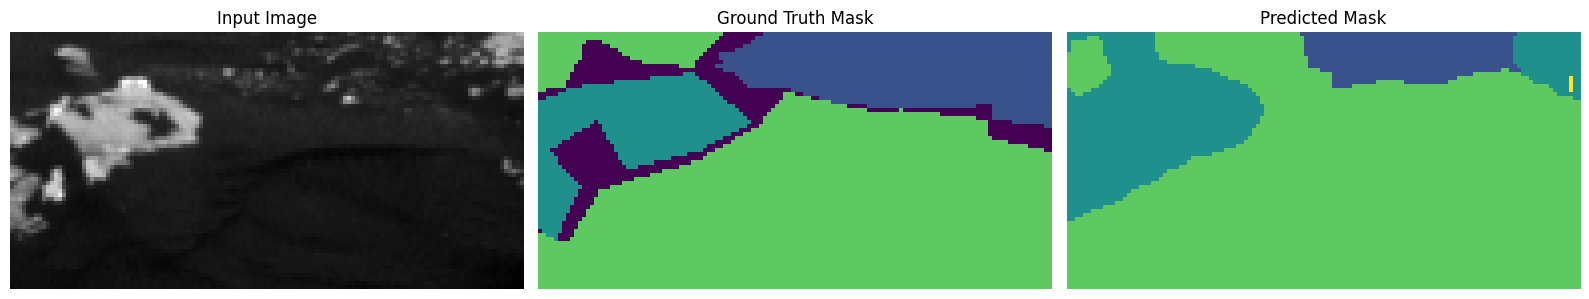

35/35 - 11s - 324ms/step - accuracy: 0.6775 - loss: 2.4912 - mean_iou: 0.6527 - val_accuracy: 0.6764 - val_loss: 2.4928 - val_mean_iou: 0.6418
Epoch 32/1000
35/35 - 11s - 313ms/step - accuracy: 0.6792 - loss: 2.4904 - mean_iou: 0.6489 - val_accuracy: 0.6579 - val_loss: 2.5068 - val_mean_iou: 0.6099
Epoch 33/1000
35/35 - 11s - 313ms/step - accuracy: 0.6767 - loss: 2.4903 - mean_iou: 0.6391 - val_accuracy: 0.5846 - val_loss: 2.6044 - val_mean_iou: 0.4655
Epoch 34/1000
35/35 - 11s - 313ms/step - accuracy: 0.6800 - loss: 2.4883 - mean_iou: 0.6474 - val_accuracy: 0.6472 - val_loss: 2.5363 - val_mean_iou: 0.5778
Epoch 35/1000
35/35 - 11s - 313ms/step - accuracy: 0.6813 - loss: 2.4881 - mean_iou: 0.6562 - val_accuracy: 0.6079 - val_loss: 2.6038 - val_mean_iou: 0.5201
Epoch 36/1000


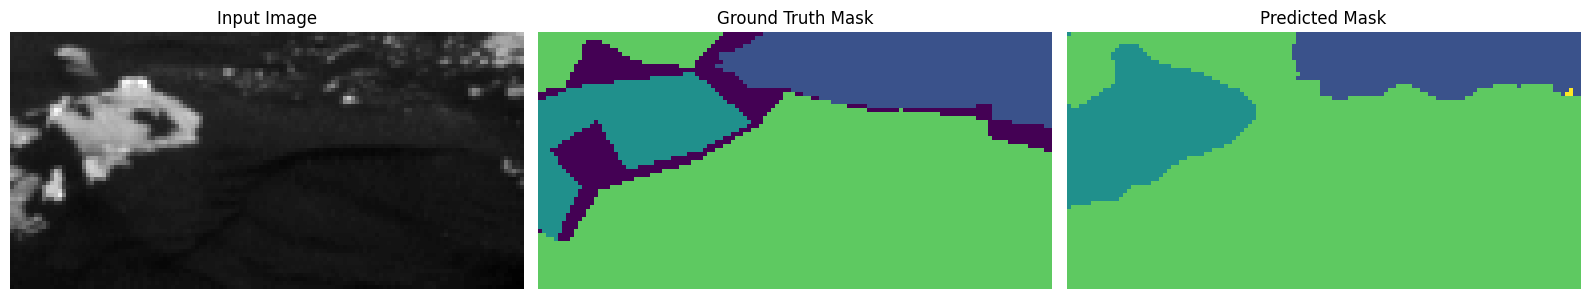

35/35 - 11s - 322ms/step - accuracy: 0.6789 - loss: 2.4874 - mean_iou: 0.6486 - val_accuracy: 0.6547 - val_loss: 2.5086 - val_mean_iou: 0.6469
Epoch 37/1000
35/35 - 11s - 313ms/step - accuracy: 0.6824 - loss: 2.4788 - mean_iou: 0.5334 - val_accuracy: 0.6717 - val_loss: 2.4968 - val_mean_iou: 0.6389
Epoch 38/1000
35/35 - 11s - 314ms/step - accuracy: 0.6785 - loss: 2.4881 - mean_iou: 0.6577 - val_accuracy: 0.6130 - val_loss: 2.5621 - val_mean_iou: 0.5337
Epoch 39/1000
35/35 - 11s - 313ms/step - accuracy: 0.6842 - loss: 2.4766 - mean_iou: 0.6668 - val_accuracy: 0.6596 - val_loss: 2.5037 - val_mean_iou: 0.6041
Epoch 40/1000
35/35 - 11s - 313ms/step - accuracy: 0.6812 - loss: 2.4826 - mean_iou: 0.6418 - val_accuracy: 0.6677 - val_loss: 2.4988 - val_mean_iou: 0.6135
Epoch 41/1000


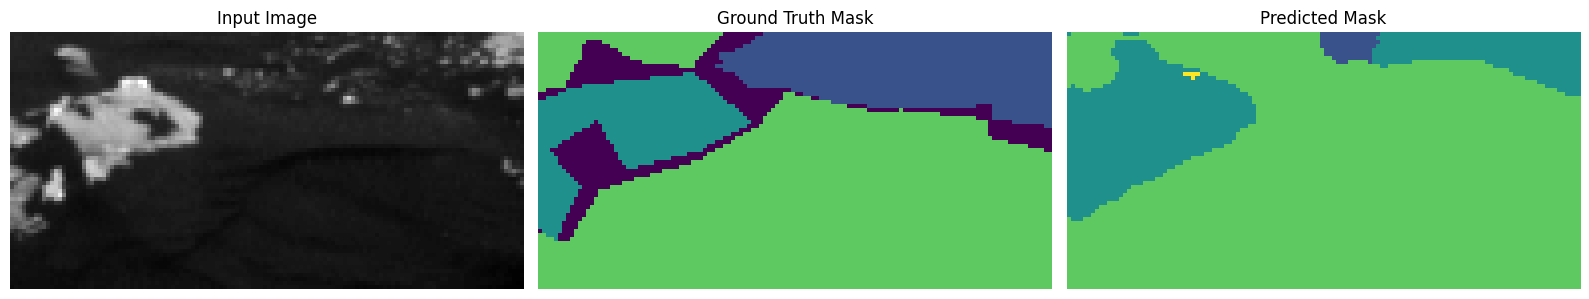

35/35 - 11s - 322ms/step - accuracy: 0.6863 - loss: 2.4748 - mean_iou: 0.6665 - val_accuracy: 0.6531 - val_loss: 2.5147 - val_mean_iou: 0.5859
Epoch 42/1000
35/35 - 11s - 313ms/step - accuracy: 0.6832 - loss: 2.4781 - mean_iou: 0.6621 - val_accuracy: 0.6288 - val_loss: 2.5428 - val_mean_iou: 0.6108
Epoch 43/1000
35/35 - 11s - 314ms/step - accuracy: 0.6869 - loss: 2.4702 - mean_iou: 0.6736 - val_accuracy: 0.6869 - val_loss: 2.4760 - val_mean_iou: 0.6704
Epoch 44/1000
35/35 - 11s - 315ms/step - accuracy: 0.6835 - loss: 2.4763 - mean_iou: 0.6694 - val_accuracy: 0.6910 - val_loss: 2.4699 - val_mean_iou: 0.6729
Epoch 45/1000
35/35 - 11s - 315ms/step - accuracy: 0.6790 - loss: 2.4829 - mean_iou: 0.6586 - val_accuracy: 0.6802 - val_loss: 2.4902 - val_mean_iou: 0.6746
Epoch 46/1000


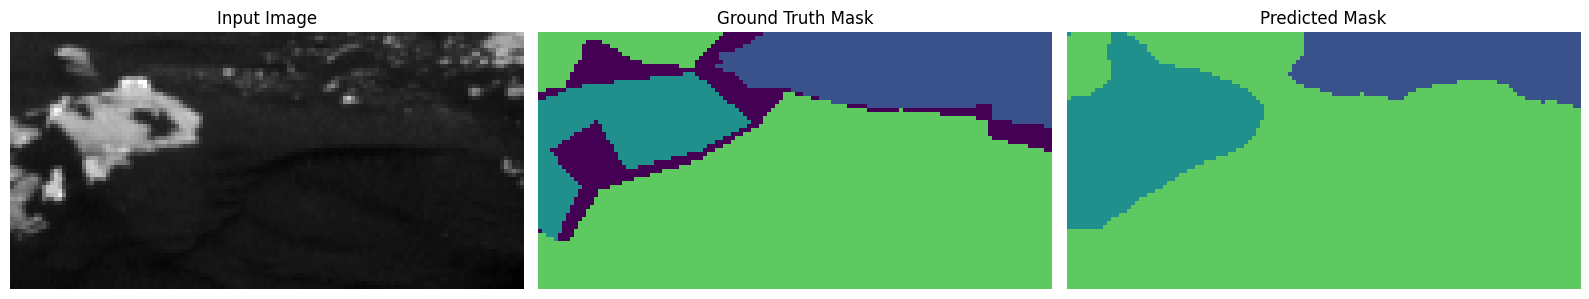

35/35 - 11s - 322ms/step - accuracy: 0.6915 - loss: 2.4687 - mean_iou: 0.6817 - val_accuracy: 0.6874 - val_loss: 2.4721 - val_mean_iou: 0.6752
Epoch 47/1000
35/35 - 11s - 315ms/step - accuracy: 0.6888 - loss: 2.4687 - mean_iou: 0.6766 - val_accuracy: 0.6976 - val_loss: 2.4578 - val_mean_iou: 0.7002
Epoch 48/1000
35/35 - 11s - 313ms/step - accuracy: 0.6968 - loss: 2.4588 - mean_iou: 0.6927 - val_accuracy: 0.6702 - val_loss: 2.4948 - val_mean_iou: 0.6409
Epoch 49/1000
35/35 - 11s - 313ms/step - accuracy: 0.6892 - loss: 2.4672 - mean_iou: 0.6794 - val_accuracy: 0.6276 - val_loss: 2.5646 - val_mean_iou: 0.5514
Epoch 50/1000
35/35 - 11s - 314ms/step - accuracy: 0.6928 - loss: 2.4623 - mean_iou: 0.6855 - val_accuracy: 0.6840 - val_loss: 2.4713 - val_mean_iou: 0.7076
Epoch 51/1000


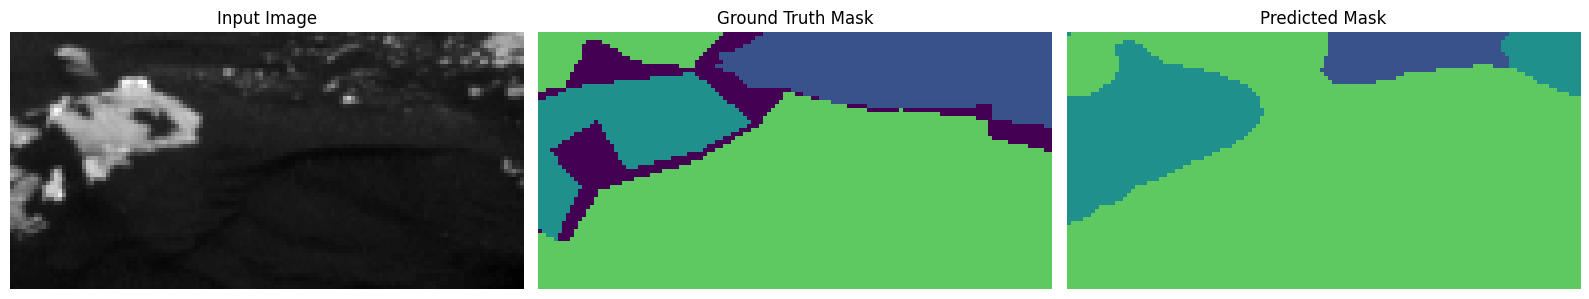

35/35 - 11s - 324ms/step - accuracy: 0.6855 - loss: 2.4681 - mean_iou: 0.6849 - val_accuracy: 0.6345 - val_loss: 2.5248 - val_mean_iou: 0.5980
Epoch 52/1000
35/35 - 11s - 314ms/step - accuracy: 0.6896 - loss: 2.4670 - mean_iou: 0.6947 - val_accuracy: 0.6984 - val_loss: 2.4535 - val_mean_iou: 0.7131
Epoch 53/1000
35/35 - 11s - 313ms/step - accuracy: 0.6935 - loss: 2.4610 - mean_iou: 0.6903 - val_accuracy: 0.6592 - val_loss: 2.5032 - val_mean_iou: 0.6390
Epoch 54/1000
35/35 - 11s - 313ms/step - accuracy: 0.6920 - loss: 2.4620 - mean_iou: 0.6764 - val_accuracy: 0.6305 - val_loss: 2.5479 - val_mean_iou: 0.5571
Epoch 55/1000
35/35 - 11s - 313ms/step - accuracy: 0.6859 - loss: 2.4712 - mean_iou: 0.6630 - val_accuracy: 0.5912 - val_loss: 2.6154 - val_mean_iou: 0.4960
Epoch 56/1000


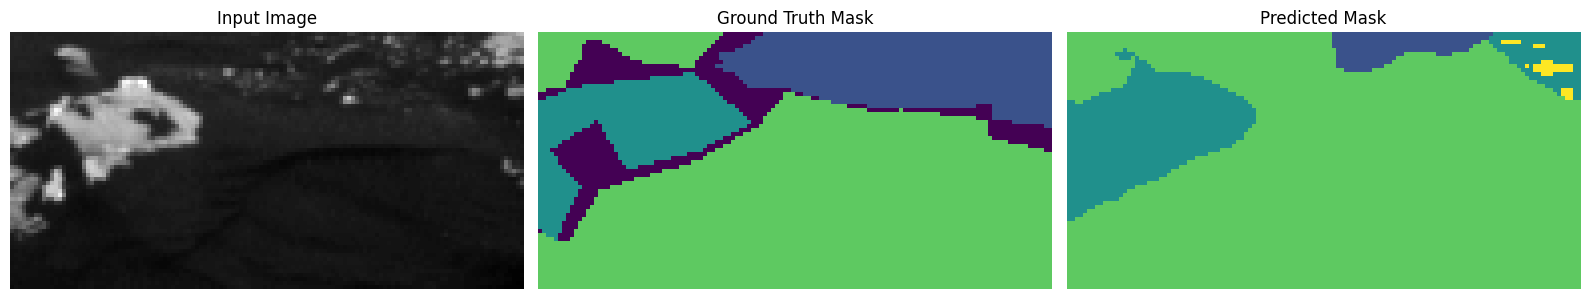

35/35 - 11s - 320ms/step - accuracy: 0.6858 - loss: 2.4676 - mean_iou: 0.6811 - val_accuracy: 0.6873 - val_loss: 2.4677 - val_mean_iou: 0.6638
Epoch 57/1000
35/35 - 11s - 313ms/step - accuracy: 0.6911 - loss: 2.4633 - mean_iou: 0.6886 - val_accuracy: 0.6743 - val_loss: 2.4817 - val_mean_iou: 0.6974
Epoch 58/1000
35/35 - 11s - 313ms/step - accuracy: 0.6903 - loss: 2.4642 - mean_iou: 0.6834 - val_accuracy: 0.6676 - val_loss: 2.4936 - val_mean_iou: 0.6561
Epoch 59/1000
35/35 - 11s - 313ms/step - accuracy: 0.6893 - loss: 2.4684 - mean_iou: 0.6815 - val_accuracy: 0.6687 - val_loss: 2.4944 - val_mean_iou: 0.6274
Epoch 60/1000
35/35 - 11s - 313ms/step - accuracy: 0.6981 - loss: 2.4540 - mean_iou: 0.6984 - val_accuracy: 0.6616 - val_loss: 2.5121 - val_mean_iou: 0.6035
Epoch 61/1000


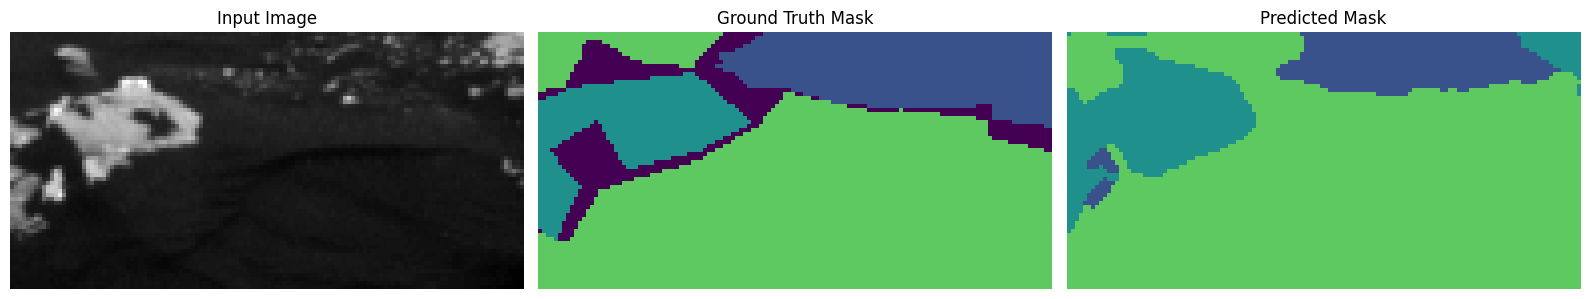

35/35 - 11s - 323ms/step - accuracy: 0.6971 - loss: 2.4565 - mean_iou: 0.6814 - val_accuracy: 0.6946 - val_loss: 2.4698 - val_mean_iou: 0.5657
Epoch 62/1000
35/35 - 11s - 313ms/step - accuracy: 0.6982 - loss: 2.4525 - mean_iou: 0.7073 - val_accuracy: 0.5952 - val_loss: 2.5935 - val_mean_iou: 0.4979
Epoch 63/1000
35/35 - 11s - 313ms/step - accuracy: 0.6948 - loss: 2.4569 - mean_iou: 0.6818 - val_accuracy: 0.6366 - val_loss: 2.5301 - val_mean_iou: 0.5987
Epoch 64/1000
35/35 - 11s - 313ms/step - accuracy: 0.6934 - loss: 2.4569 - mean_iou: 0.7040 - val_accuracy: 0.6769 - val_loss: 2.4776 - val_mean_iou: 0.6672
Epoch 65/1000
35/35 - 11s - 313ms/step - accuracy: 0.6879 - loss: 2.4664 - mean_iou: 0.6772 - val_accuracy: 0.6705 - val_loss: 2.4945 - val_mean_iou: 0.6153
Epoch 66/1000


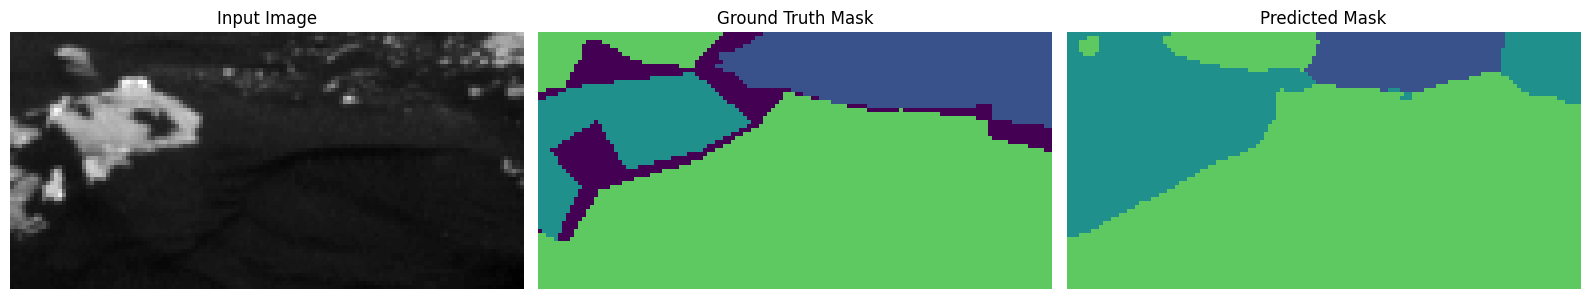

35/35 - 11s - 322ms/step - accuracy: 0.6932 - loss: 2.4612 - mean_iou: 0.6953 - val_accuracy: 0.6906 - val_loss: 2.4657 - val_mean_iou: 0.7334
Epoch 67/1000
35/35 - 11s - 313ms/step - accuracy: 0.6962 - loss: 2.4531 - mean_iou: 0.7091 - val_accuracy: 0.6772 - val_loss: 2.4798 - val_mean_iou: 0.6633
Epoch 68/1000
35/35 - 11s - 313ms/step - accuracy: 0.6969 - loss: 2.4540 - mean_iou: 0.7120 - val_accuracy: 0.6866 - val_loss: 2.4647 - val_mean_iou: 0.7060
Epoch 69/1000
35/35 - 11s - 313ms/step - accuracy: 0.7026 - loss: 2.4465 - mean_iou: 0.7269 - val_accuracy: 0.6779 - val_loss: 2.4826 - val_mean_iou: 0.6836
Epoch 70/1000
35/35 - 11s - 313ms/step - accuracy: 0.7021 - loss: 2.4440 - mean_iou: 0.7180 - val_accuracy: 0.6889 - val_loss: 2.4666 - val_mean_iou: 0.6902
Epoch 71/1000


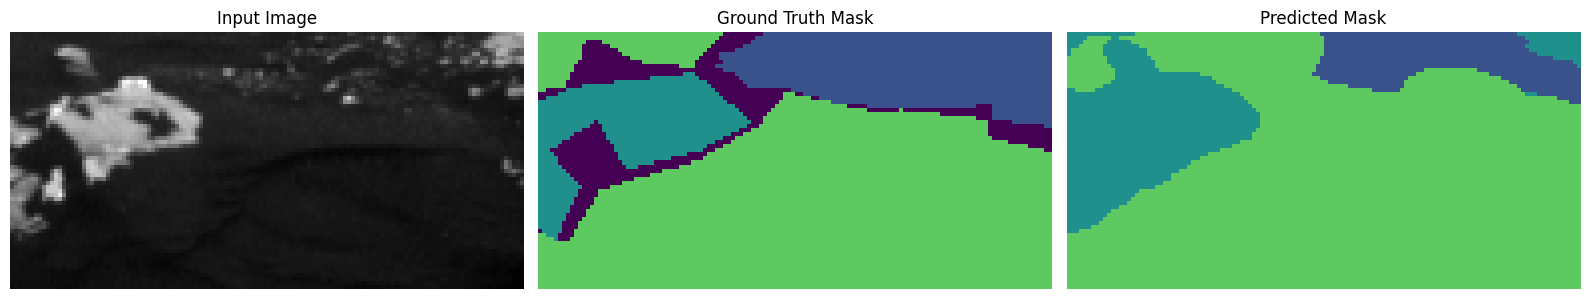

35/35 - 11s - 320ms/step - accuracy: 0.6963 - loss: 2.4592 - mean_iou: 0.7110 - val_accuracy: 0.6912 - val_loss: 2.4701 - val_mean_iou: 0.6947
Epoch 72/1000
35/35 - 11s - 313ms/step - accuracy: 0.6909 - loss: 2.4625 - mean_iou: 0.6853 - val_accuracy: 0.6936 - val_loss: 2.4552 - val_mean_iou: 0.7310
Epoch 73/1000
35/35 - 11s - 313ms/step - accuracy: 0.6976 - loss: 2.4547 - mean_iou: 0.7036 - val_accuracy: 0.6046 - val_loss: 2.5794 - val_mean_iou: 0.5202
Epoch 74/1000
35/35 - 11s - 313ms/step - accuracy: 0.6975 - loss: 2.4569 - mean_iou: 0.6901 - val_accuracy: 0.6783 - val_loss: 2.4693 - val_mean_iou: 0.6957
Epoch 75/1000
35/35 - 11s - 312ms/step - accuracy: 0.6983 - loss: 2.4546 - mean_iou: 0.7113 - val_accuracy: 0.6874 - val_loss: 2.4673 - val_mean_iou: 0.7145
Epoch 76/1000


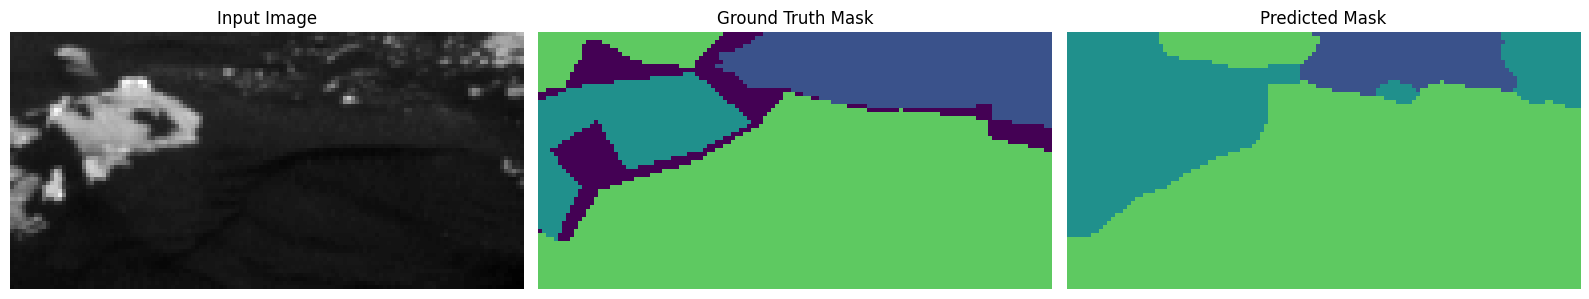

35/35 - 11s - 323ms/step - accuracy: 0.6968 - loss: 2.4565 - mean_iou: 0.6969 - val_accuracy: 0.6667 - val_loss: 2.4985 - val_mean_iou: 0.6652
Epoch 77/1000
35/35 - 11s - 313ms/step - accuracy: 0.6999 - loss: 2.4503 - mean_iou: 0.7325 - val_accuracy: 0.6890 - val_loss: 2.4613 - val_mean_iou: 0.7156
Epoch 78/1000
35/35 - 11s - 313ms/step - accuracy: 0.7003 - loss: 2.4476 - mean_iou: 0.7335 - val_accuracy: 0.7001 - val_loss: 2.4486 - val_mean_iou: 0.7134
Epoch 79/1000
35/35 - 11s - 314ms/step - accuracy: 0.7085 - loss: 2.4388 - mean_iou: 0.7600 - val_accuracy: 0.7069 - val_loss: 2.4385 - val_mean_iou: 0.7821
Epoch 80/1000
35/35 - 11s - 313ms/step - accuracy: 0.7001 - loss: 2.4470 - mean_iou: 0.7397 - val_accuracy: 0.6534 - val_loss: 2.5392 - val_mean_iou: 0.6484
Epoch 81/1000


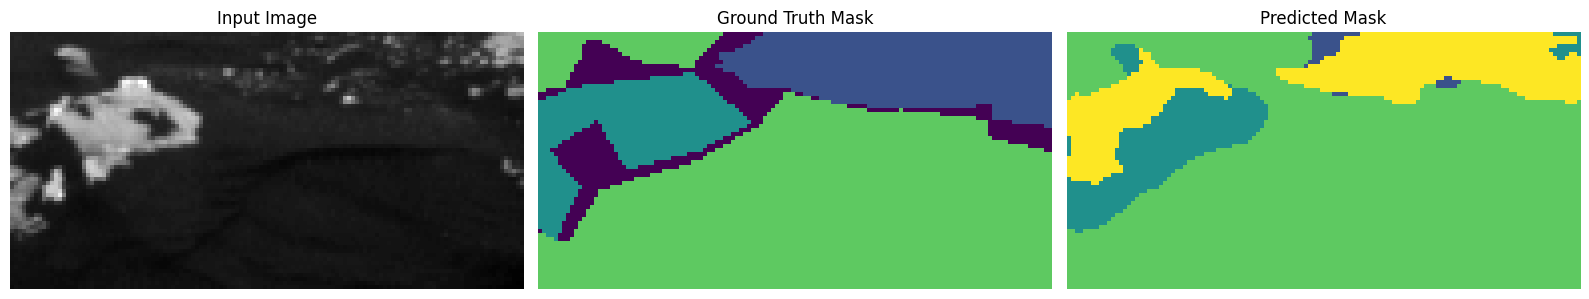

35/35 - 11s - 323ms/step - accuracy: 0.7020 - loss: 2.4460 - mean_iou: 0.7242 - val_accuracy: 0.6732 - val_loss: 2.4995 - val_mean_iou: 0.6233
Epoch 82/1000
35/35 - 11s - 313ms/step - accuracy: 0.7022 - loss: 2.4448 - mean_iou: 0.7417 - val_accuracy: 0.6637 - val_loss: 2.5025 - val_mean_iou: 0.6543
Epoch 83/1000
35/35 - 11s - 313ms/step - accuracy: 0.7015 - loss: 2.4483 - mean_iou: 0.7224 - val_accuracy: 0.6833 - val_loss: 2.4663 - val_mean_iou: 0.7001
Epoch 84/1000
35/35 - 11s - 313ms/step - accuracy: 0.7057 - loss: 2.4442 - mean_iou: 0.7368 - val_accuracy: 0.6123 - val_loss: 2.5903 - val_mean_iou: 0.5964
Epoch 85/1000
35/35 - 11s - 313ms/step - accuracy: 0.7044 - loss: 2.4393 - mean_iou: 0.7184 - val_accuracy: 0.6815 - val_loss: 2.4753 - val_mean_iou: 0.6669
Epoch 86/1000


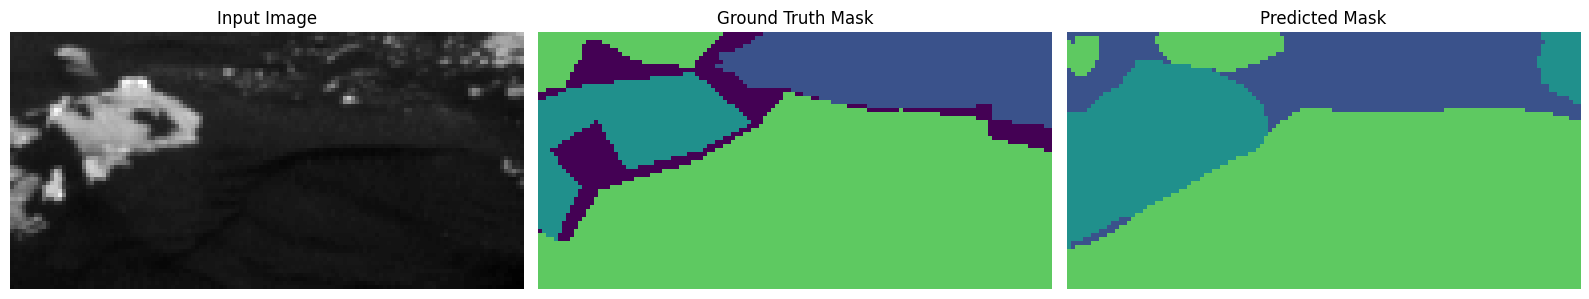

35/35 - 11s - 324ms/step - accuracy: 0.7065 - loss: 2.4413 - mean_iou: 0.7501 - val_accuracy: 0.7013 - val_loss: 2.4485 - val_mean_iou: 0.7415
Epoch 87/1000
35/35 - 11s - 313ms/step - accuracy: 0.7014 - loss: 2.4453 - mean_iou: 0.7240 - val_accuracy: 0.6864 - val_loss: 2.4678 - val_mean_iou: 0.7238
Epoch 88/1000
35/35 - 11s - 313ms/step - accuracy: 0.7011 - loss: 2.4490 - mean_iou: 0.7258 - val_accuracy: 0.7056 - val_loss: 2.4393 - val_mean_iou: 0.7649
Epoch 89/1000
35/35 - 11s - 313ms/step - accuracy: 0.7052 - loss: 2.4399 - mean_iou: 0.7626 - val_accuracy: 0.6606 - val_loss: 2.5026 - val_mean_iou: 0.6962
Epoch 90/1000
35/35 - 11s - 313ms/step - accuracy: 0.6997 - loss: 2.4499 - mean_iou: 0.7176 - val_accuracy: 0.6733 - val_loss: 2.4744 - val_mean_iou: 0.6722
Epoch 91/1000


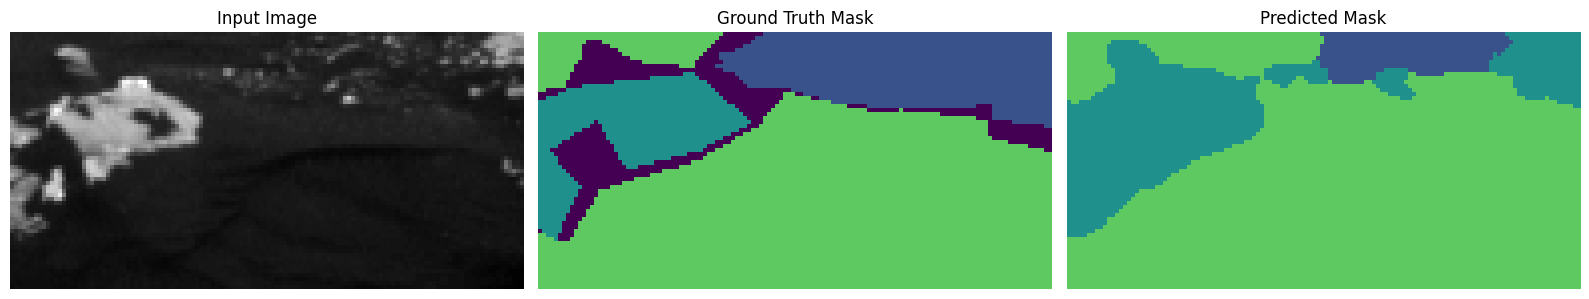

35/35 - 11s - 323ms/step - accuracy: 0.7061 - loss: 2.4403 - mean_iou: 0.7485 - val_accuracy: 0.7124 - val_loss: 2.4328 - val_mean_iou: 0.7749
Epoch 92/1000
35/35 - 11s - 313ms/step - accuracy: 0.7003 - loss: 2.4464 - mean_iou: 0.7411 - val_accuracy: 0.6569 - val_loss: 2.5183 - val_mean_iou: 0.6791
Epoch 93/1000
35/35 - 11s - 313ms/step - accuracy: 0.7037 - loss: 2.4443 - mean_iou: 0.7473 - val_accuracy: 0.6604 - val_loss: 2.4915 - val_mean_iou: 0.6759
Epoch 94/1000
35/35 - 11s - 313ms/step - accuracy: 0.7083 - loss: 2.4368 - mean_iou: 0.7582 - val_accuracy: 0.5300 - val_loss: 2.7236 - val_mean_iou: 0.4659
Epoch 95/1000
35/35 - 11s - 313ms/step - accuracy: 0.7043 - loss: 2.4424 - mean_iou: 0.7326 - val_accuracy: 0.7028 - val_loss: 2.4437 - val_mean_iou: 0.7415
Epoch 96/1000


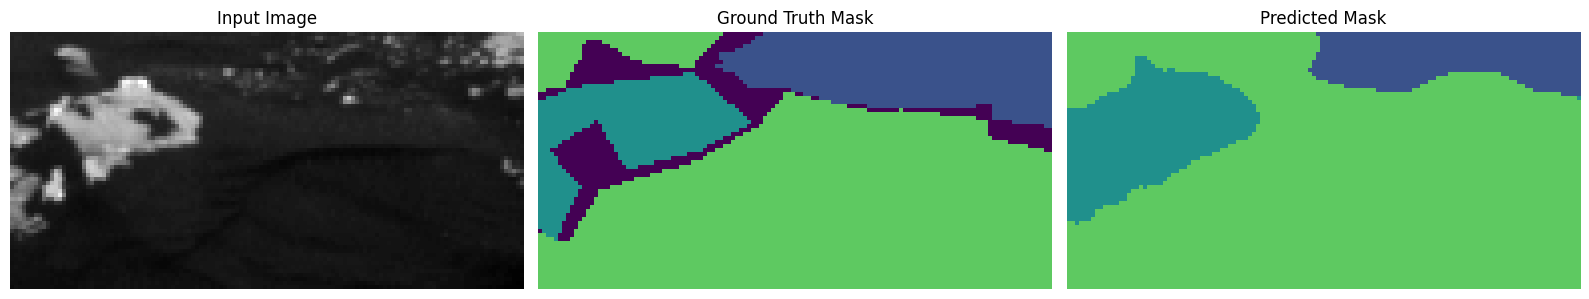

35/35 - 11s - 323ms/step - accuracy: 0.7099 - loss: 2.4366 - mean_iou: 0.7611 - val_accuracy: 0.7111 - val_loss: 2.4314 - val_mean_iou: 0.7694
Epoch 97/1000
35/35 - 11s - 314ms/step - accuracy: 0.7078 - loss: 2.4374 - mean_iou: 0.7458 - val_accuracy: 0.7125 - val_loss: 2.4294 - val_mean_iou: 0.7958
Epoch 98/1000
35/35 - 11s - 313ms/step - accuracy: 0.7099 - loss: 2.4362 - mean_iou: 0.7339 - val_accuracy: 0.7092 - val_loss: 2.4335 - val_mean_iou: 0.7788
Epoch 99/1000
35/35 - 11s - 313ms/step - accuracy: 0.7106 - loss: 2.4358 - mean_iou: 0.7485 - val_accuracy: 0.6959 - val_loss: 2.4540 - val_mean_iou: 0.7316
Epoch 100/1000
35/35 - 11s - 312ms/step - accuracy: 0.7068 - loss: 2.4413 - mean_iou: 0.7361 - val_accuracy: 0.6643 - val_loss: 2.5172 - val_mean_iou: 0.6065
Epoch 101/1000


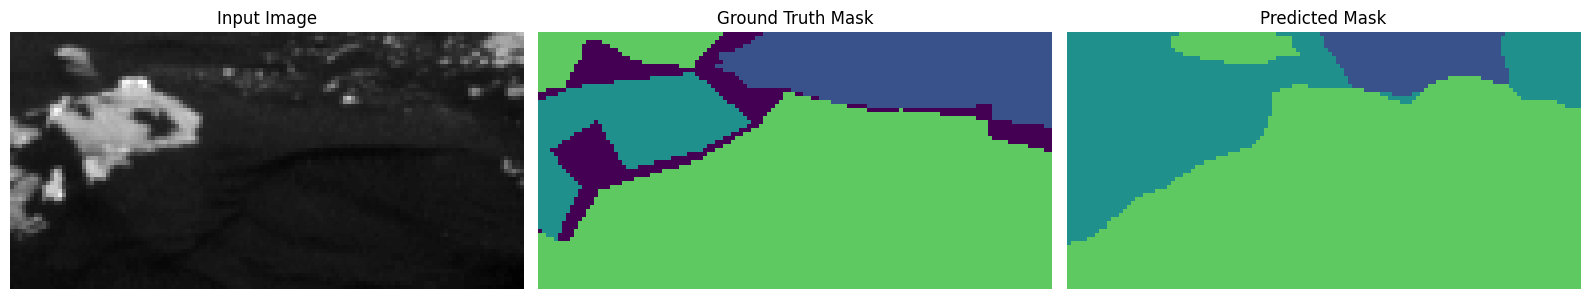

35/35 - 12s - 339ms/step - accuracy: 0.7037 - loss: 2.4407 - mean_iou: 0.7383 - val_accuracy: 0.6671 - val_loss: 2.5130 - val_mean_iou: 0.6913
Epoch 102/1000
35/35 - 11s - 313ms/step - accuracy: 0.7045 - loss: 2.4391 - mean_iou: 0.7552 - val_accuracy: 0.7132 - val_loss: 2.4293 - val_mean_iou: 0.7899
Epoch 103/1000
35/35 - 11s - 313ms/step - accuracy: 0.7066 - loss: 2.4362 - mean_iou: 0.7477 - val_accuracy: 0.6415 - val_loss: 2.5220 - val_mean_iou: 0.6706
Epoch 104/1000
35/35 - 11s - 313ms/step - accuracy: 0.7064 - loss: 2.4360 - mean_iou: 0.7477 - val_accuracy: 0.6986 - val_loss: 2.4456 - val_mean_iou: 0.7428
Epoch 105/1000
35/35 - 11s - 314ms/step - accuracy: 0.7133 - loss: 2.4312 - mean_iou: 0.7588 - val_accuracy: 0.7098 - val_loss: 2.4302 - val_mean_iou: 0.8033
Epoch 106/1000


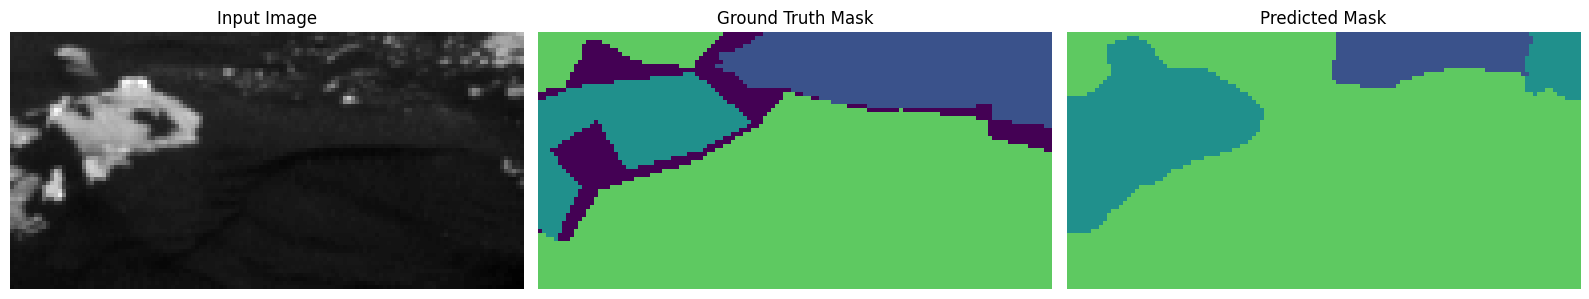

35/35 - 11s - 321ms/step - accuracy: 0.7083 - loss: 2.4339 - mean_iou: 0.7812 - val_accuracy: 0.6961 - val_loss: 2.4426 - val_mean_iou: 0.7794
Epoch 107/1000
35/35 - 11s - 313ms/step - accuracy: 0.7009 - loss: 2.4428 - mean_iou: 0.7470 - val_accuracy: 0.6523 - val_loss: 2.5170 - val_mean_iou: 0.6456
Epoch 108/1000
35/35 - 11s - 313ms/step - accuracy: 0.7118 - loss: 2.4305 - mean_iou: 0.7730 - val_accuracy: 0.6777 - val_loss: 2.4799 - val_mean_iou: 0.6829
Epoch 109/1000
35/35 - 11s - 313ms/step - accuracy: 0.7123 - loss: 2.4321 - mean_iou: 0.7574 - val_accuracy: 0.6828 - val_loss: 2.4680 - val_mean_iou: 0.7236
Epoch 110/1000
35/35 - 11s - 313ms/step - accuracy: 0.7122 - loss: 2.4330 - mean_iou: 0.7730 - val_accuracy: 0.5666 - val_loss: 2.6856 - val_mean_iou: 0.5670
Epoch 111/1000


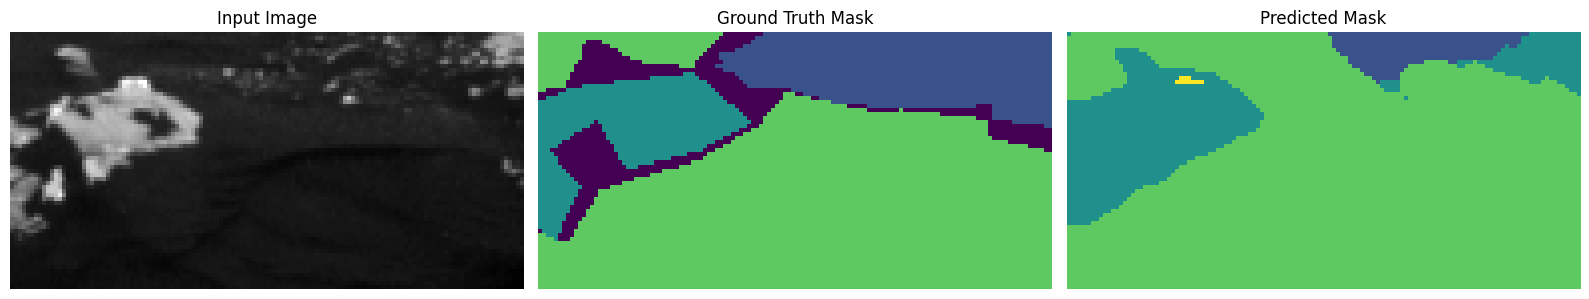

35/35 - 11s - 324ms/step - accuracy: 0.7071 - loss: 2.4356 - mean_iou: 0.7442 - val_accuracy: 0.6125 - val_loss: 2.5894 - val_mean_iou: 0.6172
Epoch 112/1000
35/35 - 11s - 312ms/step - accuracy: 0.7021 - loss: 2.4481 - mean_iou: 0.7201 - val_accuracy: 0.5396 - val_loss: 3.0797 - val_mean_iou: 0.4608
Epoch 113/1000
35/35 - 11s - 313ms/step - accuracy: 0.7102 - loss: 2.4311 - mean_iou: 0.7614 - val_accuracy: 0.7161 - val_loss: 2.4239 - val_mean_iou: 0.8028
Epoch 114/1000
35/35 - 11s - 313ms/step - accuracy: 0.7163 - loss: 2.4244 - mean_iou: 0.7981 - val_accuracy: 0.7064 - val_loss: 2.4293 - val_mean_iou: 0.8006
Epoch 115/1000
35/35 - 11s - 313ms/step - accuracy: 0.7076 - loss: 2.4351 - mean_iou: 0.7648 - val_accuracy: 0.6937 - val_loss: 2.4528 - val_mean_iou: 0.7402
Epoch 116/1000


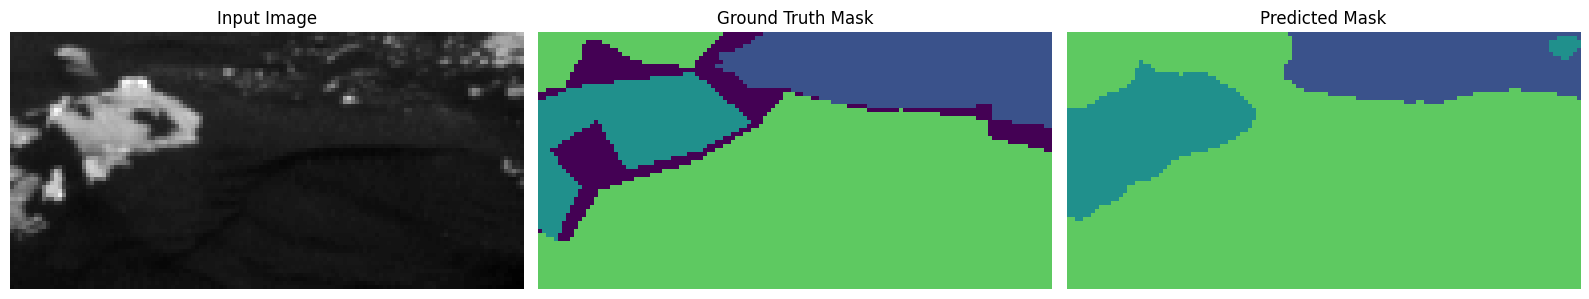

35/35 - 11s - 321ms/step - accuracy: 0.7172 - loss: 2.4232 - mean_iou: 0.7882 - val_accuracy: 0.7102 - val_loss: 2.4285 - val_mean_iou: 0.7546
Epoch 117/1000
35/35 - 11s - 313ms/step - accuracy: 0.7138 - loss: 2.4265 - mean_iou: 0.7781 - val_accuracy: 0.7007 - val_loss: 2.4444 - val_mean_iou: 0.7481
Epoch 118/1000
35/35 - 11s - 313ms/step - accuracy: 0.7132 - loss: 2.4245 - mean_iou: 0.7958 - val_accuracy: 0.6885 - val_loss: 2.4636 - val_mean_iou: 0.6816
Epoch 119/1000
35/35 - 11s - 313ms/step - accuracy: 0.7080 - loss: 2.4357 - mean_iou: 0.7497 - val_accuracy: 0.6641 - val_loss: 2.5015 - val_mean_iou: 0.6348
Epoch 120/1000
35/35 - 11s - 313ms/step - accuracy: 0.7085 - loss: 2.4350 - mean_iou: 0.7461 - val_accuracy: 0.7073 - val_loss: 2.4486 - val_mean_iou: 0.7038
Epoch 121/1000


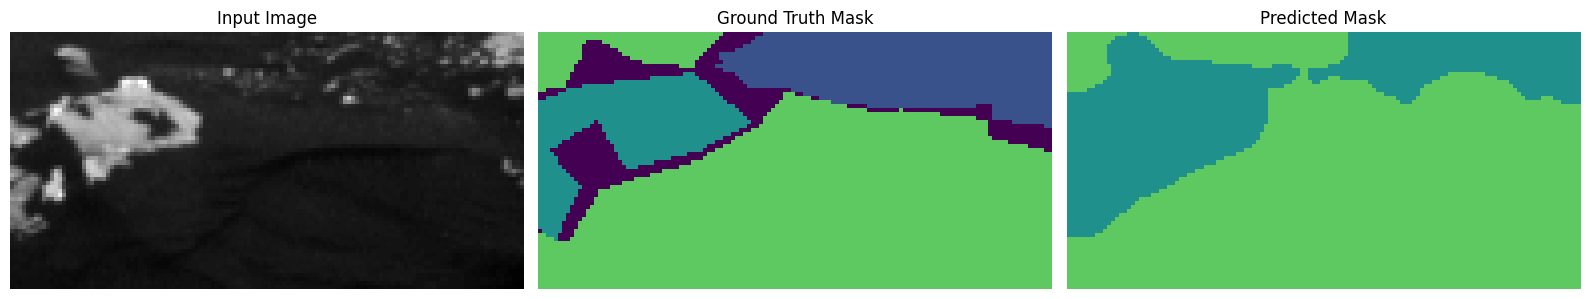

35/35 - 11s - 324ms/step - accuracy: 0.7141 - loss: 2.4257 - mean_iou: 0.7879 - val_accuracy: 0.6475 - val_loss: 2.5204 - val_mean_iou: 0.7012
Epoch 122/1000
35/35 - 11s - 313ms/step - accuracy: 0.7080 - loss: 2.4312 - mean_iou: 0.7994 - val_accuracy: 0.6900 - val_loss: 2.4709 - val_mean_iou: 0.7434
Epoch 123/1000
35/35 - 11s - 313ms/step - accuracy: 0.7127 - loss: 2.4320 - mean_iou: 0.7753 - val_accuracy: 0.6451 - val_loss: 2.5352 - val_mean_iou: 0.6013
Epoch 124/1000
35/35 - 11s - 313ms/step - accuracy: 0.7125 - loss: 2.4312 - mean_iou: 0.7603 - val_accuracy: 0.6836 - val_loss: 2.4854 - val_mean_iou: 0.6381
Epoch 125/1000
35/35 - 11s - 313ms/step - accuracy: 0.7118 - loss: 2.4308 - mean_iou: 0.8072 - val_accuracy: 0.6646 - val_loss: 2.5053 - val_mean_iou: 0.6603
Epoch 126/1000


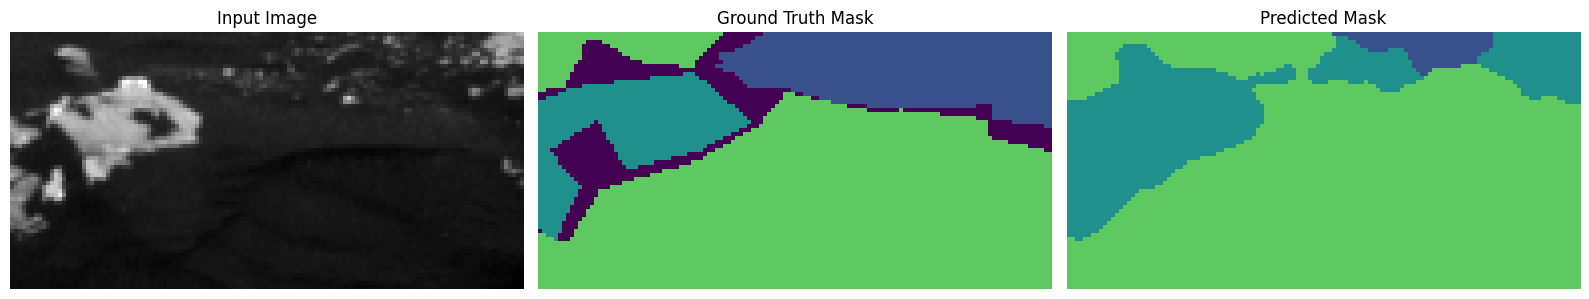

35/35 - 11s - 321ms/step - accuracy: 0.7139 - loss: 2.4288 - mean_iou: 0.7788 - val_accuracy: 0.6967 - val_loss: 2.4542 - val_mean_iou: 0.7508
Epoch 127/1000
35/35 - 11s - 313ms/step - accuracy: 0.7099 - loss: 2.4323 - mean_iou: 0.7709 - val_accuracy: 0.6659 - val_loss: 2.4942 - val_mean_iou: 0.6828
Epoch 128/1000
35/35 - 11s - 313ms/step - accuracy: 0.7151 - loss: 2.4240 - mean_iou: 0.7984 - val_accuracy: 0.6764 - val_loss: 2.4801 - val_mean_iou: 0.7454
Epoch 129/1000
35/35 - 11s - 313ms/step - accuracy: 0.7130 - loss: 2.4262 - mean_iou: 0.7925 - val_accuracy: 0.5905 - val_loss: 2.6047 - val_mean_iou: 0.6173
Epoch 130/1000
35/35 - 11s - 313ms/step - accuracy: 0.7125 - loss: 2.4282 - mean_iou: 0.7808 - val_accuracy: 0.6715 - val_loss: 2.4992 - val_mean_iou: 0.6652
Epoch 131/1000


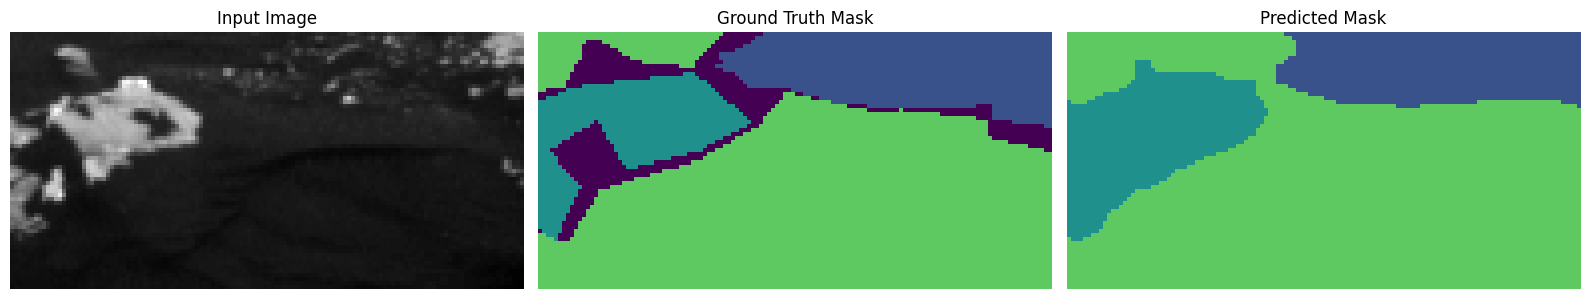

35/35 - 11s - 323ms/step - accuracy: 0.7099 - loss: 2.4315 - mean_iou: 0.7735 - val_accuracy: 0.6968 - val_loss: 2.4509 - val_mean_iou: 0.7230
Epoch 132/1000
35/35 - 11s - 313ms/step - accuracy: 0.7093 - loss: 2.4325 - mean_iou: 0.7615 - val_accuracy: 0.6819 - val_loss: 2.4769 - val_mean_iou: 0.7382
Epoch 133/1000
35/35 - 11s - 313ms/step - accuracy: 0.7135 - loss: 2.4330 - mean_iou: 0.7481 - val_accuracy: 0.6599 - val_loss: 2.5075 - val_mean_iou: 0.6096
Epoch 134/1000
35/35 - 11s - 312ms/step - accuracy: 0.7153 - loss: 2.4296 - mean_iou: 0.7736 - val_accuracy: 0.7032 - val_loss: 2.4403 - val_mean_iou: 0.7676
Epoch 135/1000
35/35 - 11s - 314ms/step - accuracy: 0.7070 - loss: 2.4333 - mean_iou: 0.7959 - val_accuracy: 0.7103 - val_loss: 2.4305 - val_mean_iou: 0.8090
Epoch 136/1000


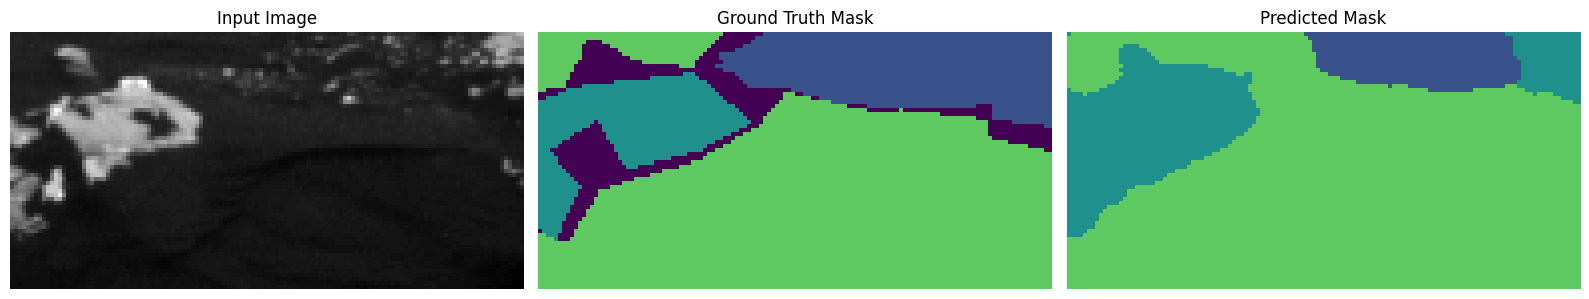

35/35 - 11s - 321ms/step - accuracy: 0.7146 - loss: 2.4202 - mean_iou: 0.8247 - val_accuracy: 0.6777 - val_loss: 2.4796 - val_mean_iou: 0.7179
Epoch 137/1000
35/35 - 11s - 313ms/step - accuracy: 0.7167 - loss: 2.4237 - mean_iou: 0.8176 - val_accuracy: 0.6936 - val_loss: 2.4495 - val_mean_iou: 0.7912
Epoch 138/1000
35/35 - 11s - 314ms/step - accuracy: 0.7091 - loss: 2.4291 - mean_iou: 0.8201 - val_accuracy: 0.6509 - val_loss: 2.5055 - val_mean_iou: 0.7081
Epoch 139/1000
35/35 - 11s - 313ms/step - accuracy: 0.7155 - loss: 2.4180 - mean_iou: 0.7907 - val_accuracy: 0.6917 - val_loss: 2.4509 - val_mean_iou: 0.7536
Epoch 140/1000
35/35 - 11s - 313ms/step - accuracy: 0.7178 - loss: 2.4165 - mean_iou: 0.8092 - val_accuracy: 0.7194 - val_loss: 2.4263 - val_mean_iou: 0.7235
Epoch 141/1000


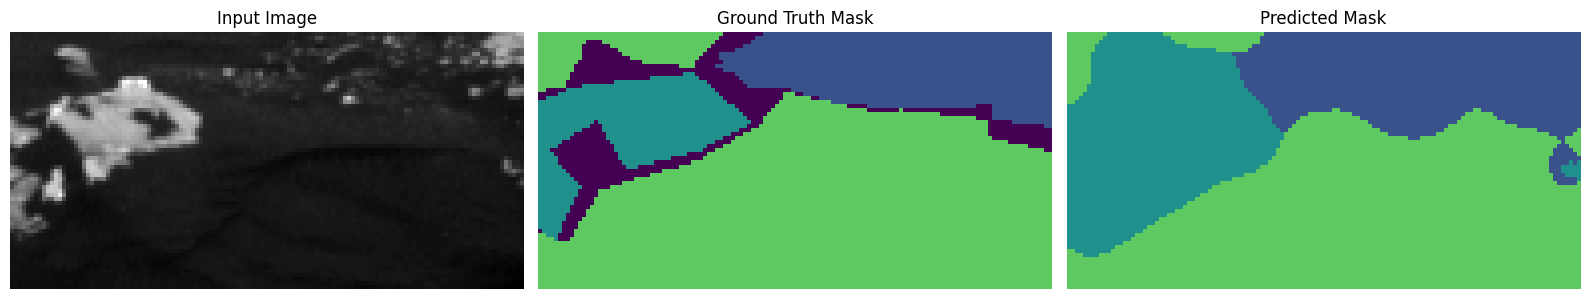

35/35 - 11s - 324ms/step - accuracy: 0.7177 - loss: 2.4196 - mean_iou: 0.8018 - val_accuracy: 0.6882 - val_loss: 2.5113 - val_mean_iou: 0.6135
Epoch 142/1000
35/35 - 11s - 313ms/step - accuracy: 0.7126 - loss: 2.4302 - mean_iou: 0.8108 - val_accuracy: 0.6848 - val_loss: 2.4777 - val_mean_iou: 0.6399
Epoch 143/1000
35/35 - 11s - 312ms/step - accuracy: 0.7190 - loss: 2.4177 - mean_iou: 0.8121 - val_accuracy: 0.7074 - val_loss: 2.4369 - val_mean_iou: 0.7907
Epoch 144/1000
35/35 - 11s - 313ms/step - accuracy: 0.7194 - loss: 2.4234 - mean_iou: 0.7864 - val_accuracy: 0.7039 - val_loss: 2.4441 - val_mean_iou: 0.7746
Epoch 145/1000
35/35 - 11s - 313ms/step - accuracy: 0.7118 - loss: 2.4339 - mean_iou: 0.7575 - val_accuracy: 0.7021 - val_loss: 2.4476 - val_mean_iou: 0.7007
Epoch 146/1000


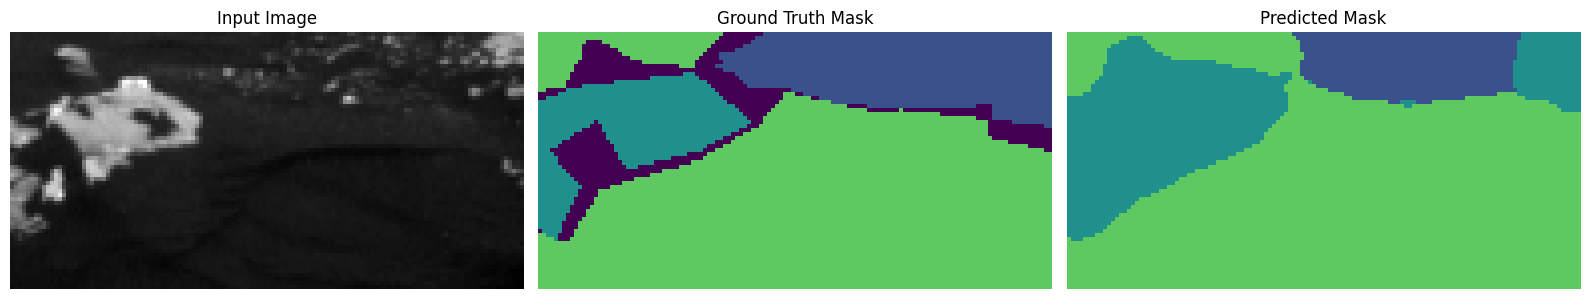

35/35 - 11s - 323ms/step - accuracy: 0.7139 - loss: 2.4277 - mean_iou: 0.7873 - val_accuracy: 0.7079 - val_loss: 2.4339 - val_mean_iou: 0.8119
Epoch 147/1000
35/35 - 11s - 315ms/step - accuracy: 0.7239 - loss: 2.4110 - mean_iou: 0.8449 - val_accuracy: 0.7261 - val_loss: 2.4118 - val_mean_iou: 0.8345
Epoch 148/1000
35/35 - 11s - 313ms/step - accuracy: 0.7158 - loss: 2.4232 - mean_iou: 0.8204 - val_accuracy: 0.6320 - val_loss: 2.5755 - val_mean_iou: 0.5523
Epoch 149/1000
35/35 - 11s - 313ms/step - accuracy: 0.7114 - loss: 2.4282 - mean_iou: 0.7982 - val_accuracy: 0.6932 - val_loss: 2.4535 - val_mean_iou: 0.7753
Epoch 150/1000
35/35 - 11s - 313ms/step - accuracy: 0.7159 - loss: 2.4191 - mean_iou: 0.8120 - val_accuracy: 0.6986 - val_loss: 2.4422 - val_mean_iou: 0.7741
Epoch 151/1000


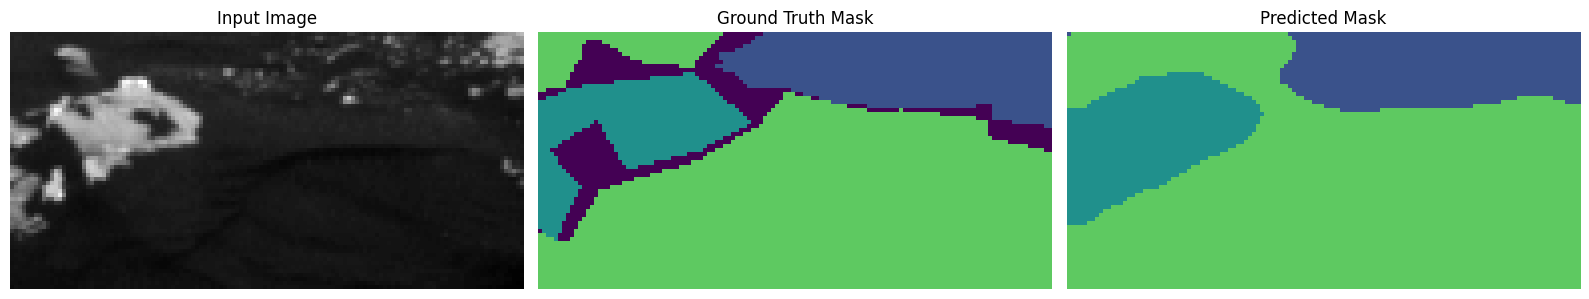

35/35 - 11s - 323ms/step - accuracy: 0.7181 - loss: 2.4157 - mean_iou: 0.8352 - val_accuracy: 0.6735 - val_loss: 2.4860 - val_mean_iou: 0.6407
Epoch 152/1000
35/35 - 11s - 313ms/step - accuracy: 0.7209 - loss: 2.4180 - mean_iou: 0.8076 - val_accuracy: 0.6953 - val_loss: 2.4570 - val_mean_iou: 0.7559
Epoch 153/1000
35/35 - 11s - 313ms/step - accuracy: 0.7150 - loss: 2.4237 - mean_iou: 0.8182 - val_accuracy: 0.6931 - val_loss: 2.4533 - val_mean_iou: 0.7442
Epoch 154/1000
35/35 - 11s - 313ms/step - accuracy: 0.7172 - loss: 2.4216 - mean_iou: 0.7935 - val_accuracy: 0.6878 - val_loss: 2.4700 - val_mean_iou: 0.7398
Epoch 155/1000
35/35 - 11s - 313ms/step - accuracy: 0.7172 - loss: 2.4216 - mean_iou: 0.7955 - val_accuracy: 0.7028 - val_loss: 2.4358 - val_mean_iou: 0.8045
Epoch 156/1000


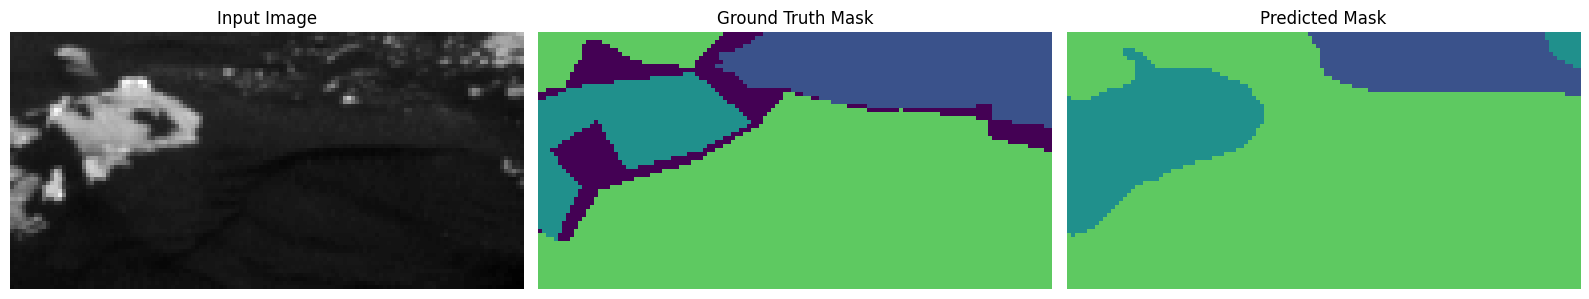

35/35 - 11s - 323ms/step - accuracy: 0.7209 - loss: 2.4145 - mean_iou: 0.8250 - val_accuracy: 0.7233 - val_loss: 2.4128 - val_mean_iou: 0.8345
Epoch 157/1000
35/35 - 11s - 313ms/step - accuracy: 0.7108 - loss: 2.4260 - mean_iou: 0.7982 - val_accuracy: 0.6656 - val_loss: 2.5018 - val_mean_iou: 0.7045
Epoch 158/1000
35/35 - 11s - 312ms/step - accuracy: 0.7175 - loss: 2.4178 - mean_iou: 0.7985 - val_accuracy: 0.6987 - val_loss: 2.4479 - val_mean_iou: 0.7772
Epoch 159/1000
35/35 - 11s - 313ms/step - accuracy: 0.7192 - loss: 2.4160 - mean_iou: 0.8110 - val_accuracy: 0.5464 - val_loss: 2.7679 - val_mean_iou: 0.4879
Epoch 160/1000
35/35 - 11s - 313ms/step - accuracy: 0.7180 - loss: 2.4237 - mean_iou: 0.8106 - val_accuracy: 0.5533 - val_loss: 2.7312 - val_mean_iou: 0.4843
Epoch 161/1000


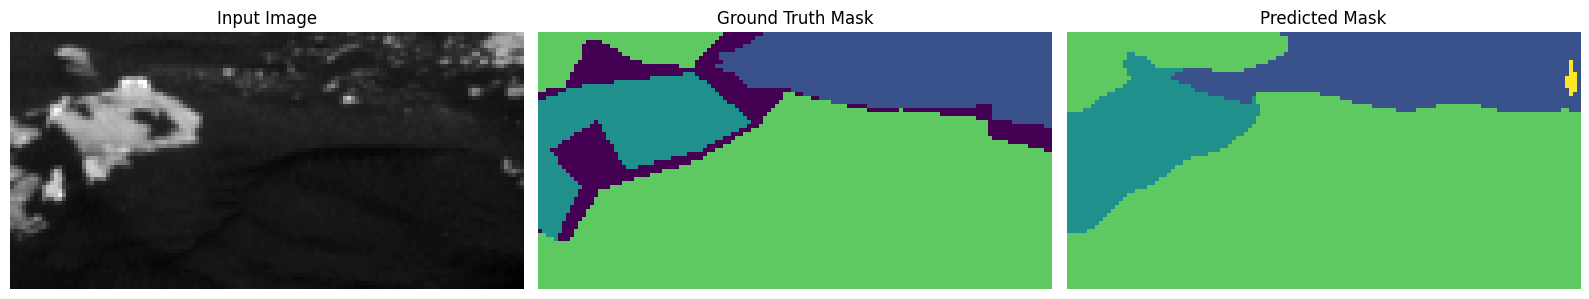

35/35 - 11s - 324ms/step - accuracy: 0.7195 - loss: 2.4222 - mean_iou: 0.7947 - val_accuracy: 0.6965 - val_loss: 2.4544 - val_mean_iou: 0.6943
Epoch 162/1000
35/35 - 11s - 313ms/step - accuracy: 0.7222 - loss: 2.4154 - mean_iou: 0.8289 - val_accuracy: 0.6822 - val_loss: 2.4727 - val_mean_iou: 0.7525
Epoch 163/1000
35/35 - 11s - 313ms/step - accuracy: 0.7221 - loss: 2.4126 - mean_iou: 0.8284 - val_accuracy: 0.6996 - val_loss: 2.4469 - val_mean_iou: 0.7914
Epoch 164/1000
35/35 - 11s - 314ms/step - accuracy: 0.7211 - loss: 2.4124 - mean_iou: 0.8452 - val_accuracy: 0.7127 - val_loss: 2.4269 - val_mean_iou: 0.8459
Epoch 165/1000
35/35 - 11s - 312ms/step - accuracy: 0.7155 - loss: 2.4209 - mean_iou: 0.7887 - val_accuracy: 0.6808 - val_loss: 2.4774 - val_mean_iou: 0.7718
Epoch 166/1000


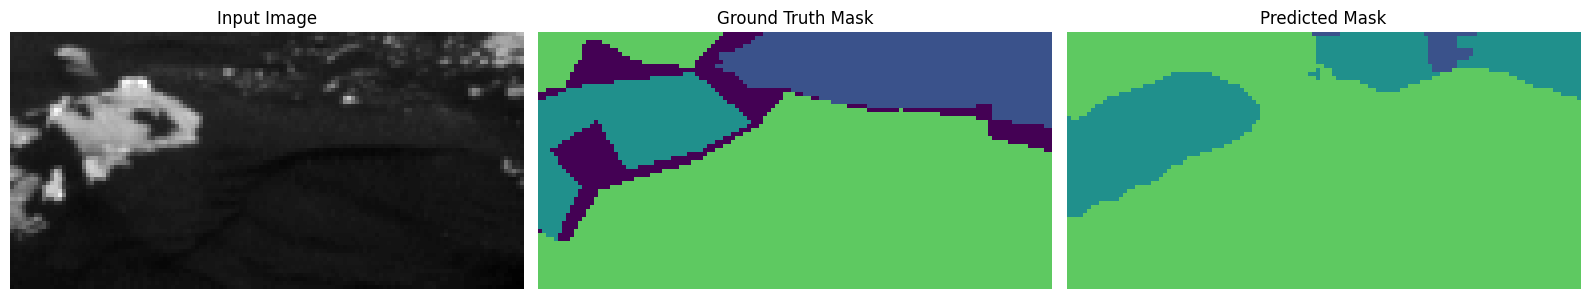

35/35 - 11s - 323ms/step - accuracy: 0.7189 - loss: 2.4212 - mean_iou: 0.8001 - val_accuracy: 0.6899 - val_loss: 2.4622 - val_mean_iou: 0.7400
Epoch 167/1000
35/35 - 11s - 313ms/step - accuracy: 0.7214 - loss: 2.4147 - mean_iou: 0.8257 - val_accuracy: 0.7102 - val_loss: 2.4327 - val_mean_iou: 0.8043
Epoch 168/1000
35/35 - 11s - 313ms/step - accuracy: 0.7168 - loss: 2.4183 - mean_iou: 0.8213 - val_accuracy: 0.5612 - val_loss: 2.6916 - val_mean_iou: 0.5594
Epoch 169/1000
35/35 - 11s - 313ms/step - accuracy: 0.7120 - loss: 2.4286 - mean_iou: 0.7962 - val_accuracy: 0.7093 - val_loss: 2.4339 - val_mean_iou: 0.7895
Epoch 170/1000
35/35 - 11s - 313ms/step - accuracy: 0.7167 - loss: 2.4209 - mean_iou: 0.7884 - val_accuracy: 0.6484 - val_loss: 2.5339 - val_mean_iou: 0.6073
Epoch 171/1000


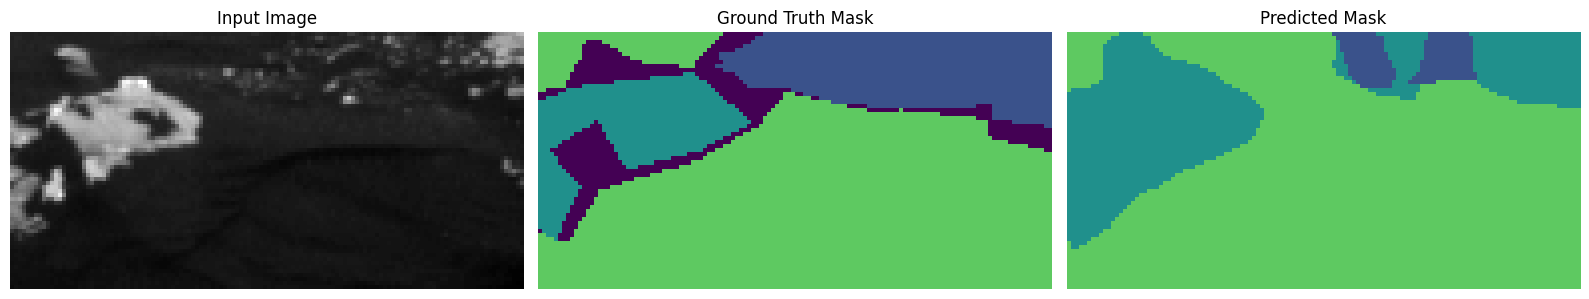

35/35 - 11s - 323ms/step - accuracy: 0.7204 - loss: 2.4185 - mean_iou: 0.8166 - val_accuracy: 0.6672 - val_loss: 2.4969 - val_mean_iou: 0.6842
Epoch 172/1000
35/35 - 11s - 313ms/step - accuracy: 0.7143 - loss: 2.4209 - mean_iou: 0.8166 - val_accuracy: 0.7120 - val_loss: 2.4270 - val_mean_iou: 0.8151
Epoch 173/1000
35/35 - 11s - 313ms/step - accuracy: 0.7162 - loss: 2.4183 - mean_iou: 0.8341 - val_accuracy: 0.7214 - val_loss: 2.4151 - val_mean_iou: 0.8448
Epoch 174/1000
35/35 - 11s - 314ms/step - accuracy: 0.7225 - loss: 2.4096 - mean_iou: 0.8517 - val_accuracy: 0.7276 - val_loss: 2.4059 - val_mean_iou: 0.8680
Epoch 175/1000
35/35 - 11s - 313ms/step - accuracy: 0.7288 - loss: 2.4022 - mean_iou: 0.8556 - val_accuracy: 0.7260 - val_loss: 2.4106 - val_mean_iou: 0.7955
Epoch 176/1000


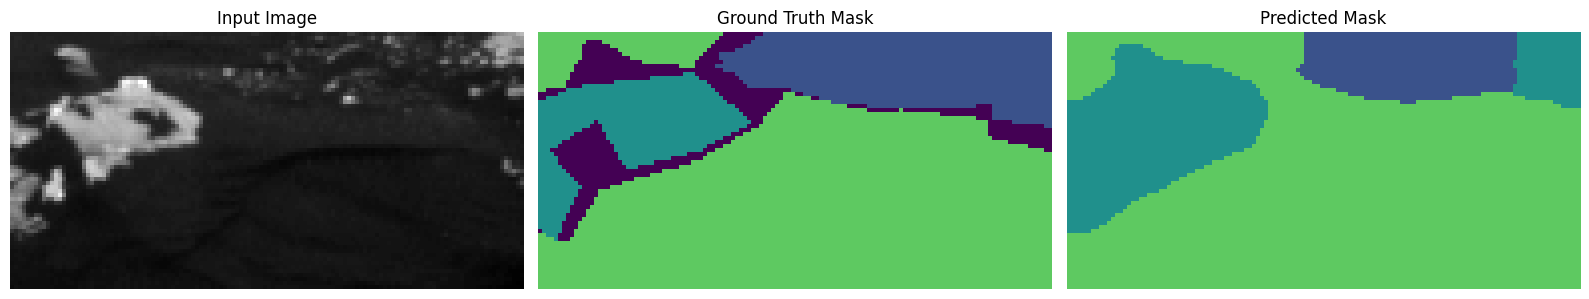

35/35 - 11s - 324ms/step - accuracy: 0.7255 - loss: 2.4037 - mean_iou: 0.8457 - val_accuracy: 0.7080 - val_loss: 2.4308 - val_mean_iou: 0.8172
Epoch 177/1000
35/35 - 11s - 313ms/step - accuracy: 0.7195 - loss: 2.4124 - mean_iou: 0.8472 - val_accuracy: 0.6974 - val_loss: 2.4458 - val_mean_iou: 0.7614
Epoch 178/1000
35/35 - 11s - 313ms/step - accuracy: 0.7214 - loss: 2.4101 - mean_iou: 0.8255 - val_accuracy: 0.6901 - val_loss: 2.4669 - val_mean_iou: 0.6780
Epoch 179/1000
35/35 - 11s - 314ms/step - accuracy: 0.7212 - loss: 2.4122 - mean_iou: 0.8140 - val_accuracy: 0.6870 - val_loss: 2.4767 - val_mean_iou: 0.6817
Epoch 180/1000
35/35 - 11s - 313ms/step - accuracy: 0.7223 - loss: 2.4106 - mean_iou: 0.8433 - val_accuracy: 0.7066 - val_loss: 2.4305 - val_mean_iou: 0.8334
Epoch 181/1000


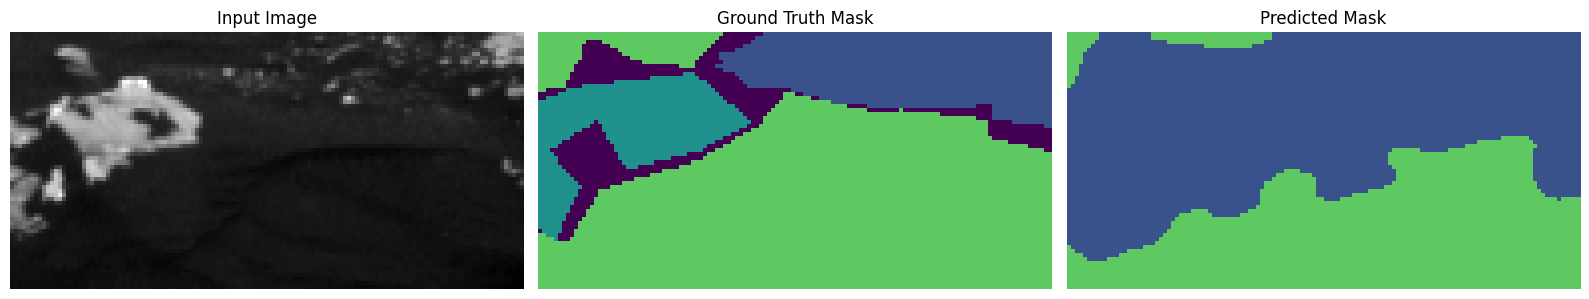

35/35 - 11s - 324ms/step - accuracy: 0.7208 - loss: 2.4119 - mean_iou: 0.8255 - val_accuracy: 0.4909 - val_loss: 3.5577 - val_mean_iou: 0.3494
Epoch 182/1000
35/35 - 11s - 313ms/step - accuracy: 0.7253 - loss: 2.4091 - mean_iou: 0.8529 - val_accuracy: 0.6912 - val_loss: 2.4483 - val_mean_iou: 0.7907
Epoch 183/1000
35/35 - 11s - 313ms/step - accuracy: 0.7244 - loss: 2.4087 - mean_iou: 0.8453 - val_accuracy: 0.6916 - val_loss: 2.4461 - val_mean_iou: 0.7820
Epoch 184/1000
35/35 - 11s - 314ms/step - accuracy: 0.7209 - loss: 2.4131 - mean_iou: 0.8184 - val_accuracy: 0.7223 - val_loss: 2.4121 - val_mean_iou: 0.8362
Epoch 185/1000
35/35 - 11s - 313ms/step - accuracy: 0.7208 - loss: 2.4136 - mean_iou: 0.8268 - val_accuracy: 0.7190 - val_loss: 2.4165 - val_mean_iou: 0.8351
Epoch 186/1000


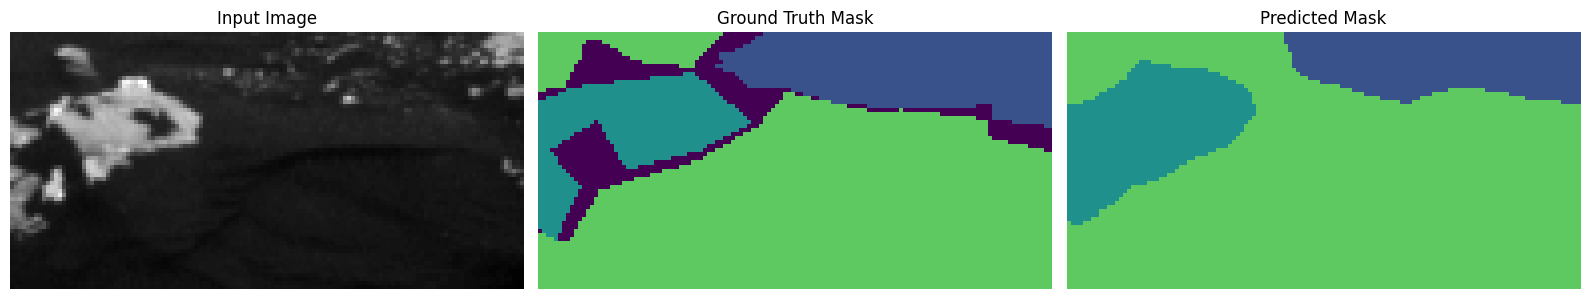

35/35 - 11s - 324ms/step - accuracy: 0.7089 - loss: 2.4318 - mean_iou: 0.8139 - val_accuracy: 0.6527 - val_loss: 2.5314 - val_mean_iou: 0.6744
Epoch 187/1000
35/35 - 11s - 314ms/step - accuracy: 0.7148 - loss: 2.4229 - mean_iou: 0.8257 - val_accuracy: 0.6387 - val_loss: 2.5778 - val_mean_iou: 0.6963
Epoch 188/1000
35/35 - 11s - 314ms/step - accuracy: 0.7195 - loss: 2.4171 - mean_iou: 0.8291 - val_accuracy: 0.7239 - val_loss: 2.4172 - val_mean_iou: 0.8260
Epoch 189/1000
35/35 - 11s - 313ms/step - accuracy: 0.7209 - loss: 2.4155 - mean_iou: 0.8458 - val_accuracy: 0.7096 - val_loss: 2.4291 - val_mean_iou: 0.7940
Epoch 190/1000
35/35 - 11s - 313ms/step - accuracy: 0.7212 - loss: 2.4118 - mean_iou: 0.8415 - val_accuracy: 0.6983 - val_loss: 2.4473 - val_mean_iou: 0.8264
Epoch 191/1000


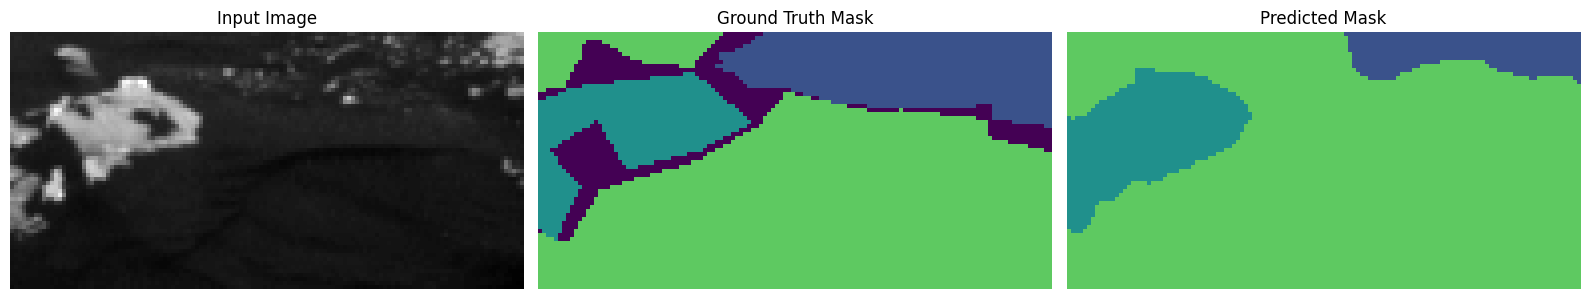

35/35 - 11s - 324ms/step - accuracy: 0.7223 - loss: 2.4100 - mean_iou: 0.8516 - val_accuracy: 0.6859 - val_loss: 2.4781 - val_mean_iou: 0.7451
Epoch 192/1000
35/35 - 11s - 313ms/step - accuracy: 0.7253 - loss: 2.4046 - mean_iou: 0.8438 - val_accuracy: 0.6883 - val_loss: 2.4606 - val_mean_iou: 0.7420
Epoch 193/1000
35/35 - 11s - 313ms/step - accuracy: 0.7219 - loss: 2.4126 - mean_iou: 0.8254 - val_accuracy: 0.7054 - val_loss: 2.4400 - val_mean_iou: 0.7314
Epoch 194/1000
35/35 - 11s - 313ms/step - accuracy: 0.7225 - loss: 2.4053 - mean_iou: 0.8320 - val_accuracy: 0.6861 - val_loss: 2.4707 - val_mean_iou: 0.7548
Epoch 195/1000
35/35 - 11s - 313ms/step - accuracy: 0.7260 - loss: 2.4023 - mean_iou: 0.8716 - val_accuracy: 0.7178 - val_loss: 2.4154 - val_mean_iou: 0.8386
Epoch 196/1000


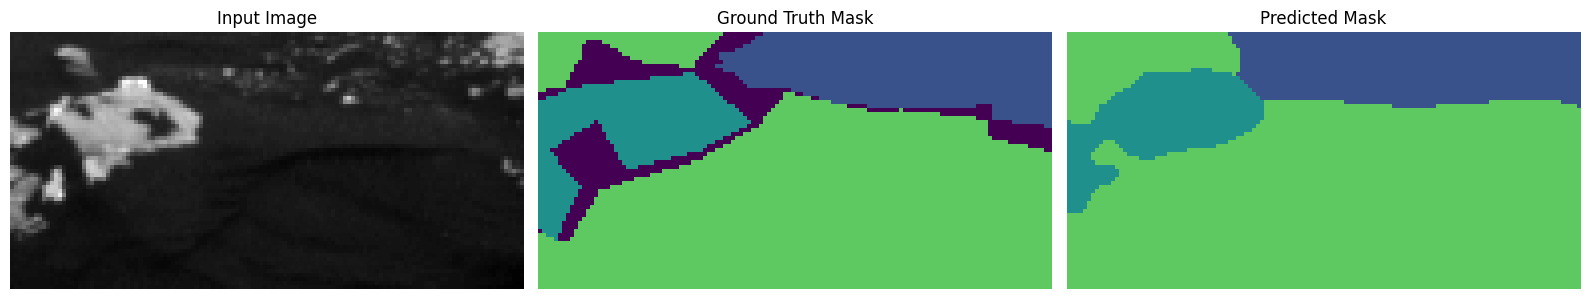

35/35 - 11s - 322ms/step - accuracy: 0.7266 - loss: 2.4013 - mean_iou: 0.8369 - val_accuracy: 0.7019 - val_loss: 2.4461 - val_mean_iou: 0.6948
Epoch 197/1000
35/35 - 11s - 313ms/step - accuracy: 0.7252 - loss: 2.4080 - mean_iou: 0.8372 - val_accuracy: 0.6986 - val_loss: 2.4496 - val_mean_iou: 0.7891
Epoch 198/1000
35/35 - 11s - 313ms/step - accuracy: 0.7249 - loss: 2.4058 - mean_iou: 0.8385 - val_accuracy: 0.7189 - val_loss: 2.4121 - val_mean_iou: 0.8298
Epoch 199/1000
35/35 - 11s - 313ms/step - accuracy: 0.7228 - loss: 2.4114 - mean_iou: 0.8228 - val_accuracy: 0.7102 - val_loss: 2.4291 - val_mean_iou: 0.7823
Epoch 200/1000
35/35 - 11s - 313ms/step - accuracy: 0.7195 - loss: 2.4160 - mean_iou: 0.8247 - val_accuracy: 0.6914 - val_loss: 2.4589 - val_mean_iou: 0.7363
Epoch 201/1000


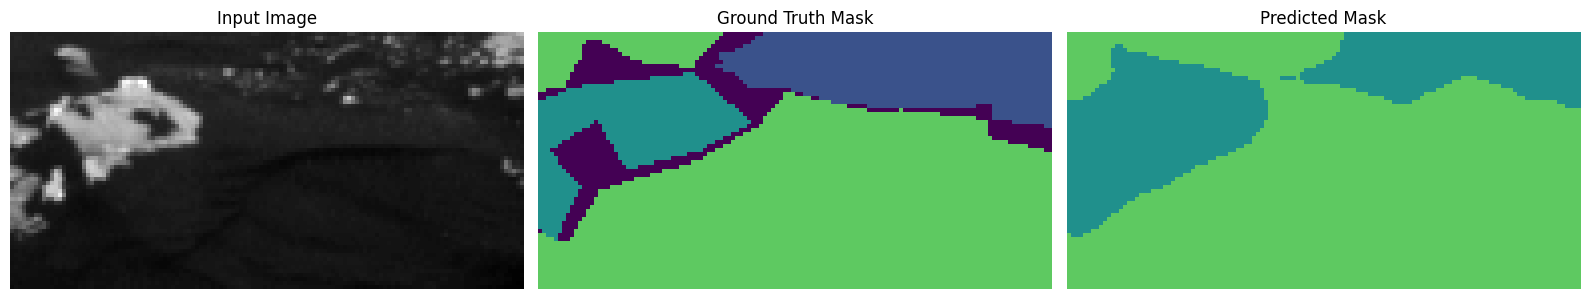

35/35 - 11s - 323ms/step - accuracy: 0.7206 - loss: 2.4141 - mean_iou: 0.8106 - val_accuracy: 0.6529 - val_loss: 2.5362 - val_mean_iou: 0.6692
Epoch 202/1000
35/35 - 11s - 313ms/step - accuracy: 0.7246 - loss: 2.4079 - mean_iou: 0.8374 - val_accuracy: 0.7184 - val_loss: 2.4155 - val_mean_iou: 0.8102
Epoch 203/1000
35/35 - 11s - 313ms/step - accuracy: 0.7181 - loss: 2.4094 - mean_iou: 0.8514 - val_accuracy: 0.5894 - val_loss: 2.6788 - val_mean_iou: 0.5767
Epoch 204/1000
35/35 - 11s - 313ms/step - accuracy: 0.7190 - loss: 2.4192 - mean_iou: 0.7885 - val_accuracy: 0.7202 - val_loss: 2.4178 - val_mean_iou: 0.7963
Final validation Mean Intersection Over Union: 86.8%
UNet_86.8.keras


In [41]:
# Train the model

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, viz_callback],
    verbose=2
).history



# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'UNet_'+str(final_val_meanIoU)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
# del model
print(model_filename)

In [42]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

314/314 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step
Predictions shape: (10022, 64, 128)
